# How do you feel my dear? (P8)

## Andrea Pio Cutrera - 965591
### Università degli Studi di Milano - _Data Science and Economics_

**Text Mining and Sentiment Analysis**

Recently, **emotion detection in text** has received attention in the literature on **sentiment analysis**. Detecting emotions is important for studying human communication in different domains, including fictional scripts for TV series and movies. The project aims at studying fictional scripts of several movies and TV series under the emotional profile. In particular, the task of the project is threefold:

1. Create a **model to predict emotions in text** using available datasets as EmoBank or WASSA-2017 or Emotion Detection from Text as training sets (see below);
2. Emotions may be represented either as **categorical classes** or in a continuous space such as Valence-Arousal-Dominance (see for example Warriner, A. B., Kuperman, V., & Brysbaert, M. (2013). Norms of valence, arousal, and dominance for 13,915 English lemmas. Behavior research methods, 45(4), 1191-1207.)
3. Exploit the model to **study an emotional profile** of the **main characters** in **one of the movies** included in the Cornell Movie--Dialogs Corpus;
4. Study how this **emotional profile changes in time along** the evolution of the movie story and how it is affected by the various relations among the different characters.

### Import all the libraries we need

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#!pip install neattext
import neattext.functions as nfx

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import demoji
demoji.download_codes()

import nltk
# nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Input, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.engine.hyperparameters import HyperParameters
import tensorflow as tf

from tensorflow.compat.v1.keras.layers import CuDNNLSTM

import warnings 
warnings.filterwarnings("ignore")

# to plot accuracy of neural nets training
def plot_history():
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Dataset: WASSA-2017 Shared Task on Emotion Intensity (EmoInt)
link: http://saifmohammad.com/WebPages/EmotionIntensity-SharedTask.html

- With the commands below you can get a folder with all the data they provide
1. Train, Development and Test data for each of the 4 emotions
2. Emotions are: **anger**, **fear**, **joy** and **sadness**

In [3]:
!mkdir emotions # create a folder called emotions

# training data
!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt
!mv anger-ratings-0to1.train.txt emotions/anger_train # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt
!mv fear-ratings-0to1.train.txt emotions/fear_train # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt
!mv joy-ratings-0to1.train.txt emotions/joy_train # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt
!mv sadness-ratings-0to1.train.txt emotions/sadness_train # move and change name

# validation data
!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/anger-ratings-0to1.dev.gold.txt
!mv anger-ratings-0to1.dev.gold.txt emotions/anger_val # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/fear-ratings-0to1.dev.gold.txt
!mv fear-ratings-0to1.dev.gold.txt emotions/fear_val # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/joy-ratings-0to1.dev.gold.txt
!mv joy-ratings-0to1.dev.gold.txt emotions/joy_val # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/sadness-ratings-0to1.dev.gold.txt
!mv sadness-ratings-0to1.dev.gold.txt emotions/sadness_val # move and change name

# testing data
!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/anger-ratings-0to1.test.gold.txt
!mv anger-ratings-0to1.test.gold.txt emotions/anger_test # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/fear-ratings-0to1.test.gold.txt
!mv fear-ratings-0to1.test.gold.txt emotions/fear_test # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/joy-ratings-0to1.test.gold.txt
!mv joy-ratings-0to1.test.gold.txt emotions/joy_test # move and change name

!curl -O http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/sadness-ratings-0to1.test.gold.txt
!mv sadness-ratings-0to1.test.gold.txt emotions/sadness_test # move and change name

mkdir: emotions: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95686  100 95686    0     0  53959      0  0:00:01  0:00:01 --:--:-- 53937
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  130k  100  130k    0     0   176k      0 --:--:-- --:--:-- --:--:--  176k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92266  100 92266    0     0   154k      0 --:--:-- --:--:-- --:--:--  154k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92977  100 92977    0     0   154k      0 --:--:-- --:--:-- --:--:--  154k
  % Total    % Received

In [4]:
working_directory = !pwd                 # get present working directory
working_directory = working_directory[0] # get the full string 
working_directory

'/Users/andreacutrera/Desktop'

In [5]:
DIR = working_directory + "/emotions"    # go inside the folder created
CATEGORIES = ["joy", "sadness", "fear", "anger"]

In [6]:
# load in variables the data just downloaded

joy_train = pd.read_csv(os.path.join(DIR, "joy_train"), sep="\t", header=None)
sadness_train = pd.read_csv(os.path.join(DIR, "sadness_train"), sep="\t", header=None)
fear_train = pd.read_csv(os.path.join(DIR, "fear_train"), sep="\t", header=None)
anger_train = pd.read_csv(os.path.join(DIR, "anger_train"), sep="\t", header=None)

joy_val = pd.read_csv(os.path.join(DIR, "joy_val"), sep="\t", header=None)
sadness_val = pd.read_csv(os.path.join(DIR, "sadness_val"), sep="\t", header=None)
fear_val = pd.read_csv(os.path.join(DIR, "fear_val"), sep="\t", header=None)
anger_val = pd.read_csv(os.path.join(DIR, "anger_val"), sep="\t", header=None)

joy_test = pd.read_csv(os.path.join(DIR, "joy_test"), sep="\t", header=None)
sadness_test = pd.read_csv(os.path.join(DIR, "sadness_test"), sep="\t", header=None)
fear_test = pd.read_csv(os.path.join(DIR, "fear_test"), sep="\t", header=None)
anger_test = pd.read_csv(os.path.join(DIR, "anger_test"), sep="\t", header=None)

In [7]:
print(joy_train.shape, sadness_train.shape, fear_train.shape, anger_train.shape)

(823, 4) (786, 4) (1147, 4) (857, 4)


In [8]:
print(joy_val.shape, sadness_val.shape, fear_val.shape, anger_val.shape)

(79, 4) (74, 4) (110, 4) (84, 4)


In [9]:
print(joy_test.shape, sadness_test.shape, fear_test.shape, anger_test.shape)

(714, 4) (673, 4) (995, 4) (760, 4)


In [10]:
# rename columns all in the same way to get homogeneous datasets which could be concatenated

joy_train.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'j'}, inplace=True)
joy_train['s'] = 0
joy_train['a'] = 0
joy_train['f'] = 0
joy_train = joy_train[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

joy_val.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'j'}, inplace=True)
joy_val['s'] = 0
joy_val['a'] = 0
joy_val['f'] = 0
joy_val = joy_val[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

joy_test.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'j'}, inplace=True)
joy_test['s'] = 0
joy_test['a'] = 0
joy_test['f'] = 0
joy_test = joy_test[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

sadness_train.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 's'}, inplace=True)
sadness_train['j'] = 0
sadness_train['a'] = 0
sadness_train['f'] = 0
sadness_train = sadness_train[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

sadness_val.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 's'}, inplace=True)
sadness_val['j'] = 0
sadness_val['a'] = 0
sadness_val['f'] = 0
sadness_val = sadness_val[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

sadness_test.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 's'}, inplace=True)
sadness_test['j'] = 0
sadness_test['a'] = 0
sadness_test['f'] = 0
sadness_test = sadness_test[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

anger_train.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'a'}, inplace=True)
anger_train['j'] = 0
anger_train['s'] = 0
anger_train['f'] = 0
anger_train = anger_train[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

anger_val.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'a'}, inplace=True)
anger_val['j'] = 0
anger_val['s'] = 0
anger_val['f'] = 0
anger_val = anger_val[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

anger_test.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'a'}, inplace=True)
anger_test['j'] = 0
anger_test['s'] = 0
anger_test['f'] = 0
anger_test = anger_test[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

fear_train.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'f'}, inplace=True)
fear_train['j'] = 0
fear_train['s'] = 0
fear_train['a'] = 0
fear_train = fear_train[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

fear_val.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'f'}, inplace=True)
fear_val['j'] = 0
fear_val['s'] = 0
fear_val['a'] = 0
fear_val = fear_val[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

fear_test.rename(columns={0: 'id', 1: 'text', 2: 'sentiment', 3: 'f'}, inplace=True)
fear_test['j'] = 0
fear_test['s'] = 0
fear_test['a'] = 0
fear_test = fear_test[['id', 'text', 'sentiment', 'j', 's', 'f', 'a']]

In [11]:
# concatenate the datasets in order to get 3 separated datasets: train, test, validation

data = pd.concat([joy_train,
                  sadness_train,
                  fear_train,
                  anger_train,
                  joy_test,
                  sadness_test,
                  fear_test,
                  anger_test,
                  joy_val,
                  sadness_val,
                  fear_val,
                  anger_val])

In [12]:
data.head(2)

,id,text,sentiment,j,s,f,a
0,30000,Just got back from seeing @GaryDelaney in Burs...,joy,0.980,0.0,0.0,0.0
1,30001,Oh dear an evening of absolute hilarity I don'...,joy,0.958,0.0,0.0,0.0


In [13]:
data.shape

(7102, 7)

### Now we start to clean up our texts

In [14]:
# clean text functions
# https://github.com/Jcharis/neattext/blob/master/neattext/functions/functions.py

def clean_emoji_output(text):
    return re.sub(":", " ", text)

def strip_lowercase(text):
    return text.strip().lower()


def clean_text(data):
    data['clean_text'] = data['text'].apply(nfx.remove_emails)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_numbers)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_urls)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_userhandles)
    data['clean_text'] = data['clean_text'].apply(demoji.replace_with_desc)
    data['clean_text'] = data['clean_text'].apply(clean_emoji_output)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_special_characters)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_bad_quotes)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_html_tags)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_punctuations)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_stopwords)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_multiple_spaces)
    data['clean_text'] = data['clean_text'].apply(strip_lowercase)

In [15]:
# apply the functions above defined

clean_text(data)

In [16]:
# shuffle our data

data = shuffle(data, random_state=42)

### Tokenize the text we have cleaned in order to make a further normalization on words with the Lemmatizer

In [17]:
# tokenize
tt = TweetTokenizer()

data['tokenize'] = data.clean_text.str.lower().apply(tt.tokenize)

# lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
    
data['tokenize_lemmatized'] = data['tokenize'].apply(lemmatize_text)

In [18]:
data.head()

,id,text,sentiment,j,s,f,a,clean_text,tokenize,tokenize_lemmatized
100,11041,Nothing is more relentless than a dog begging ...,anger,0.000,0.000,0.0,0.479,relentless dog begging food,"[relentless, dog, begging, food]","[relentless, dog, begging, food]"
120,40980,Ok it really just sunk in that I'm seeing the ...,sadness,0.000,0.417,0.0,0.000,ok sunk im seeing goat hours wow face rolling ...,"[ok, sunk, im, seeing, goat, hours, wow, face,...","[ok, sunk, im, seeing, goat, hour, wow, face, ..."
350,41210,@MariamVeiszadeh #depressing it's so freaking ...,sadness,0.000,0.679,0.0,0.000,depressing freaking close,"[depressing, freaking, close]","[depressing, freaking, close]"
505,41365,I feel like a burden every day that I waste bu...,sadness,0.000,0.896,0.0,0.000,feel like burden day waste dont know bc discou...,"[feel, like, burden, day, waste, dont, know, b...","[feel, like, burden, day, waste, dont, know, b..."
183,31085,@partydelightsUK it's 5679787. Cannot DM you a...,joy,0.164,0.000,0.0,0.000,dm dont follow delight party fail letdown,"[dm, dont, follow, delight, party, fail, letdown]","[dm, dont, follow, delight, party, fail, letdown]"


### DeTokenize to get again a sequence of words as they were written, but with all our preprocessing applied

In [19]:
# detokenize

data['final_text'] = data.tokenize_lemmatized.apply(TreebankWordDetokenizer().detokenize)

In [20]:
data.tail()

,id,text,sentiment,j,s,f,a,clean_text,tokenize,tokenize_lemmatized,final_text
159,31061,Be content .... Life is too short.,joy,0.354,0.000,0.000,0.0,content life short,"[content, life, short]","[content, life, short]",content life short
191,21448,"@bt_uk appointment booked between 1-6 today, w...",fear,0.000,0.000,0.417,0.0,appointment booked today waited day showed req...,"[appointment, booked, today, waited, day, show...","[appointment, booked, today, waited, day, show...",appointment booked today waited day showed req...
226,21483,@Darren32895836 @FatimaFatwa it would be a gre...,fear,0.000,0.000,0.500,0.0,great opportunity settle globe fear wonders,"[great, opportunity, settle, globe, fear, wond...","[great, opportunity, settle, globe, fear, wonder]",great opportunity settle globe fear wonder
390,21647,quentin i sait aps dire eastpak i dit aspak msk,fear,0.000,0.000,0.312,0.0,quentin sait aps dire eastpak dit aspak msk,"[quentin, sait, aps, dire, eastpak, dit, aspak...","[quentin, sait, aps, dire, eastpak, dit, aspak...",quentin sait aps dire eastpak dit aspak msk
37,40037,@Markgatiss I'm surrounded by those Trump vote...,sadness,0.000,0.833,0.000,0.0,im surrounded trump voters youre right fucking...,"[im, surrounded, trump, voters, youre, right, ...","[im, surrounded, trump, voter, youre, right, f...",im surrounded trump voter youre right fucking ...


In [21]:
data.final_text.values[100]

'english pundit afraid criticise'

### Once we have cleaned our text, we can split our training texts from labels

In [22]:
# train-validation-test split has been already done

X_train, X_test, y_train, y_test = train_test_split(data.final_text,
                                                    data.sentiment,
                                                    test_size = 0.13,
                                                    random_state = 42,
                                                    stratify = data.sentiment)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size = 0.14,
                                                  random_state = 42,
                                                  stratify = y_train)

In [23]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape)

(5313,) (5313,) (924,) (924,) (865,) (865,)


In [24]:
X_train.head()

172    dear future big brother player chase dick seas...
61                       rooney shocking attempted cross
482    good thing sick coughing like ab workout maybe...
718    learning trust god quiet troubled amp restless...
56     cant wait listen new single mystery new album ...
Name: final_text, dtype: object

In [25]:
y_train.head()

172      anger
61        fear
482        joy
718    sadness
56     sadness
Name: sentiment, dtype: object

### Now encode our labels into numbers from 0 to 3, this would allow us to one-hot-encode them

In [26]:
# numerical encoding of our labels

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.fit_transform(y_test)
y_val_enc = label_encoder.fit_transform(y_val)

In [27]:
# alphabetical order
# 0: anger
# 1: fear
# 2: joy
# 3: sadness

print(y_train[29:33])
print(y_train_enc[29:33])

599       fear
528        joy
131    sadness
445      anger
Name: sentiment, dtype: object
[1 2 3 0]


In [28]:
# one-hot-encode them

y_train = to_categorical(y_train_enc)
y_val = to_categorical(y_val_enc)
y_test = to_categorical(y_test_enc)

y_train[29:33]

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

In [29]:
pd.concat([X_train, X_val])

172    dear future big brother player chase dick seas...
61                       rooney shocking attempted cross
482    good thing sick coughing like ab workout maybe...
718    learning trust god quiet troubled amp restless...
56     cant wait listen new single mystery new album ...
                             ...                        
214    amazing get stuck head cant shake memory miss ...
273    ok movie good time whilst young face tear joy ...
555             dont discouraged simple mind dont vision
371    traditionalist bored bored bored rule cheerful...
153    conversion random fellow passenger melbourne y...
Name: final_text, Length: 6178, dtype: object

In [30]:
# here we use the Tokenizer of keras, fitting it on all our training and validation data, 
# getting the sequences and the words with the corresponding index (unique words)

num_words = 10000

tokenizer = Tokenizer(nb_words=num_words)
tokenizer.fit_on_texts(pd.concat([X_train, X_val]))

sequences = tokenizer.texts_to_sequences(pd.concat([X_train, X_val]))
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=50)

Found 10899 unique tokens.


In [31]:
# from these commands you can download the pre-trained word embeddings

# !curl -O http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

### Use the embedding with 200 features for each unique word

In [32]:
GLOVE_DIR = os.getcwd()
embeddings_index = {}

f = open(os.path.join(GLOVE_DIR, 'glove/glove.6B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [33]:
# Get the embedding matrix which is going to be put in the Embedding layer of the neural network architecture

embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [34]:
# Create the keras Embedding layer with 10K words specifying that the weights here are not trainable
# because we are using a pre-trained model (glove twitter words with 200 features)

embedding_layer = Embedding(len(word_index) + 1,
                            200,
                            weights=[embedding_matrix],
                            input_length=50,
                            trainable=False)

In [35]:
# Convert texts into some numeric sequences and make the length of all numeric sequences equal 

X_train_seq = tokenizer.texts_to_sequences(X_train) 
X_train_pad = pad_sequences(X_train_seq, maxlen = 50, padding = 'post') 

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen = 50, padding = 'post')

X_val_seq = tokenizer.texts_to_sequences(X_val)
X_val_pad = pad_sequences(X_val_seq, maxlen = 50, padding = 'post')

X_train_pad = np.array(X_train_pad)
X_test_pad = np.array(X_test_pad)
X_val_pad = np.array(X_val_pad)

## 1. Model with pre-trained glove Embedding and 3 LSTMs regularized by 3 dropouts
Note that if you have a GPU available, just specify **CuDNNLSTM** instead of **LSTM**. It does the same things but **5x** faster.

In [36]:
# number of classes

class_num = 4

### Build the model for the hyperparameter tuning, which will allow us to make a correct model selection

In [39]:
# Build the model
def build_model(hp):
    model = tf.keras.Sequential(
        [
            embedding_layer,
            Dropout(0.2),
            Bidirectional(LSTM(hp.Choice('lstm_1', values=[50, 100]), 
                               return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(hp.Choice('lstm_2', values=[100, 150]), 
                               return_sequences=True)),
            Dropout(0.2),
            Bidirectional(LSTM(hp.Choice('lstm_3', values=[50, 25]), 
                               return_sequences=False)),
            Dense(class_num, 
                  activation = 'softmax')
        ])

    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
        
    return model

In [46]:
# Build the tuner
tuner = Hyperband(build_model, 
                  objective='val_accuracy', 
                  max_epochs=20,
                  hyperband_iterations=1,
                  directory=DIR,
                  project_name='deep-learning-experiment')

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=3, 
                                              min_delta=0.0001)

In [48]:
# Start hyper-parameter search
tuner.search(x=X_train_pad,
             y=y_train,
             epochs=20,
             batch_size=64,
             use_multiprocessing=True,
             validation_data=(X_val_pad, y_val),
             callbacks=[early_stop])

Epoch 1/3
84/84 [==============================] - ETA: 7:15 - loss: 1.3922 - accuracy: 0.26 - ETA: 13s - loss: 1.3831 - accuracy: 0.2969 - ETA: 13s - loss: 1.3682 - accuracy: 0.359 - ETA: 13s - loss: 1.3729 - accuracy: 0.332 - ETA: 12s - loss: 1.3670 - accuracy: 0.340 - ETA: 12s - loss: 1.3658 - accuracy: 0.330 - ETA: 12s - loss: 1.3591 - accuracy: 0.330 - ETA: 12s - loss: 1.3495 - accuracy: 0.343 - ETA: 12s - loss: 1.3434 - accuracy: 0.352 - ETA: 12s - loss: 1.3327 - accuracy: 0.379 - ETA: 12s - loss: 1.3224 - accuracy: 0.404 - ETA: 11s - loss: 1.3161 - accuracy: 0.403 - ETA: 11s - loss: 1.3088 - accuracy: 0.405 - ETA: 11s - loss: 1.3044 - accuracy: 0.409 - ETA: 11s - loss: 1.3045 - accuracy: 0.408 - ETA: 11s - loss: 1.2957 - accuracy: 0.416 - ETA: 11s - loss: 1.2868 - accuracy: 0.425 - ETA: 11s - loss: 1.2769 - accuracy: 0.432 - ETA: 11s - loss: 1.2767 - accuracy: 0.433 - ETA: 10s - loss: 1.2704 - accuracy: 0.435 - ETA: 10s - loss: 1.2649 - accuracy: 0.443 - ETA: 10s - loss: 1.2666 

84/84 [==============================] - ETA: 18s - loss: 0.8477 - accuracy: 0.671 - ETA: 18s - loss: 0.7942 - accuracy: 0.671 - ETA: 18s - loss: 0.7304 - accuracy: 0.718 - ETA: 18s - loss: 0.7203 - accuracy: 0.714 - ETA: 18s - loss: 0.7085 - accuracy: 0.718 - ETA: 18s - loss: 0.6926 - accuracy: 0.726 - ETA: 18s - loss: 0.6785 - accuracy: 0.732 - ETA: 17s - loss: 0.6859 - accuracy: 0.722 - ETA: 17s - loss: 0.6871 - accuracy: 0.725 - ETA: 17s - loss: 0.6730 - accuracy: 0.732 - ETA: 17s - loss: 0.6701 - accuracy: 0.738 - ETA: 16s - loss: 0.6898 - accuracy: 0.730 - ETA: 16s - loss: 0.7039 - accuracy: 0.724 - ETA: 16s - loss: 0.7063 - accuracy: 0.723 - ETA: 16s - loss: 0.7041 - accuracy: 0.727 - ETA: 15s - loss: 0.7082 - accuracy: 0.724 - ETA: 15s - loss: 0.7111 - accuracy: 0.726 - ETA: 15s - loss: 0.7068 - accuracy: 0.727 - ETA: 15s - loss: 0.7047 - accuracy: 0.728 - ETA: 14s - loss: 0.7111 - accuracy: 0.726 - ETA: 14s - loss: 0.7188 - accuracy: 0.724 - ETA: 14s - loss: 0.7170 - accuracy:

Epoch 1/3
84/84 [==============================] - ETA: 8:22 - loss: 1.3810 - accuracy: 0.25 - ETA: 13s - loss: 1.3683 - accuracy: 0.2812 - ETA: 12s - loss: 1.3706 - accuracy: 0.333 - ETA: 12s - loss: 1.3756 - accuracy: 0.351 - ETA: 11s - loss: 1.3723 - accuracy: 0.356 - ETA: 11s - loss: 1.3765 - accuracy: 0.338 - ETA: 11s - loss: 1.3711 - accuracy: 0.343 - ETA: 11s - loss: 1.3725 - accuracy: 0.332 - ETA: 11s - loss: 1.3688 - accuracy: 0.333 - ETA: 11s - loss: 1.3643 - accuracy: 0.334 - ETA: 11s - loss: 1.3591 - accuracy: 0.340 - ETA: 11s - loss: 1.3594 - accuracy: 0.334 - ETA: 11s - loss: 1.3573 - accuracy: 0.335 - ETA: 10s - loss: 1.3545 - accuracy: 0.339 - ETA: 10s - loss: 1.3514 - accuracy: 0.339 - ETA: 10s - loss: 1.3501 - accuracy: 0.336 - ETA: 10s - loss: 1.3489 - accuracy: 0.333 - ETA: 10s - loss: 1.3463 - accuracy: 0.335 - ETA: 10s - loss: 1.3429 - accuracy: 0.342 - ETA: 10s - loss: 1.3397 - accuracy: 0.350 - ETA: 9s - loss: 1.3371 - accuracy: 0.357 - ETA: 9s - loss: 1.3346 - 

84/84 [==============================] - ETA: 14s - loss: 0.8378 - accuracy: 0.718 - ETA: 14s - loss: 0.8206 - accuracy: 0.710 - ETA: 14s - loss: 0.8097 - accuracy: 0.708 - ETA: 14s - loss: 0.8320 - accuracy: 0.695 - ETA: 13s - loss: 0.8037 - accuracy: 0.703 - ETA: 13s - loss: 0.7976 - accuracy: 0.700 - ETA: 13s - loss: 0.7929 - accuracy: 0.700 - ETA: 13s - loss: 0.7956 - accuracy: 0.707 - ETA: 13s - loss: 0.7878 - accuracy: 0.710 - ETA: 13s - loss: 0.7908 - accuracy: 0.707 - ETA: 13s - loss: 0.7851 - accuracy: 0.711 - ETA: 12s - loss: 0.7773 - accuracy: 0.712 - ETA: 12s - loss: 0.7765 - accuracy: 0.712 - ETA: 12s - loss: 0.7604 - accuracy: 0.721 - ETA: 12s - loss: 0.7583 - accuracy: 0.720 - ETA: 12s - loss: 0.7502 - accuracy: 0.720 - ETA: 11s - loss: 0.7482 - accuracy: 0.722 - ETA: 11s - loss: 0.7507 - accuracy: 0.722 - ETA: 11s - loss: 0.7390 - accuracy: 0.728 - ETA: 11s - loss: 0.7316 - accuracy: 0.732 - ETA: 11s - loss: 0.7298 - accuracy: 0.734 - ETA: 10s - loss: 0.7257 - accuracy:

Epoch 1/3
84/84 [==============================] - ETA: 11:44 - loss: 1.3759 - accuracy: 0.312 - ETA: 29s - loss: 1.3592 - accuracy: 0.3828  - ETA: 27s - loss: 1.3700 - accuracy: 0.359 - ETA: 25s - loss: 1.3743 - accuracy: 0.347 - ETA: 24s - loss: 1.3736 - accuracy: 0.331 - ETA: 24s - loss: 1.3728 - accuracy: 0.320 - ETA: 23s - loss: 1.3746 - accuracy: 0.308 - ETA: 22s - loss: 1.3668 - accuracy: 0.322 - ETA: 22s - loss: 1.3664 - accuracy: 0.319 - ETA: 21s - loss: 1.3639 - accuracy: 0.326 - ETA: 21s - loss: 1.3614 - accuracy: 0.325 - ETA: 20s - loss: 1.3560 - accuracy: 0.337 - ETA: 20s - loss: 1.3577 - accuracy: 0.328 - ETA: 19s - loss: 1.3540 - accuracy: 0.340 - ETA: 19s - loss: 1.3539 - accuracy: 0.336 - ETA: 19s - loss: 1.3471 - accuracy: 0.349 - ETA: 18s - loss: 1.3452 - accuracy: 0.355 - ETA: 18s - loss: 1.3423 - accuracy: 0.362 - ETA: 18s - loss: 1.3402 - accuracy: 0.361 - ETA: 17s - loss: 1.3368 - accuracy: 0.370 - ETA: 17s - loss: 1.3327 - accuracy: 0.373 - ETA: 17s - loss: 1.33

84/84 [==============================] - ETA: 21s - loss: 0.6645 - accuracy: 0.781 - ETA: 21s - loss: 0.6805 - accuracy: 0.765 - ETA: 21s - loss: 0.6975 - accuracy: 0.760 - ETA: 21s - loss: 0.7203 - accuracy: 0.746 - ETA: 20s - loss: 0.7461 - accuracy: 0.737 - ETA: 20s - loss: 0.7450 - accuracy: 0.739 - ETA: 20s - loss: 0.7510 - accuracy: 0.741 - ETA: 20s - loss: 0.7745 - accuracy: 0.722 - ETA: 19s - loss: 0.7713 - accuracy: 0.732 - ETA: 19s - loss: 0.7749 - accuracy: 0.726 - ETA: 19s - loss: 0.7671 - accuracy: 0.731 - ETA: 19s - loss: 0.7621 - accuracy: 0.730 - ETA: 19s - loss: 0.7656 - accuracy: 0.727 - ETA: 18s - loss: 0.7673 - accuracy: 0.726 - ETA: 18s - loss: 0.7719 - accuracy: 0.722 - ETA: 18s - loss: 0.7704 - accuracy: 0.724 - ETA: 18s - loss: 0.7670 - accuracy: 0.723 - ETA: 17s - loss: 0.7660 - accuracy: 0.725 - ETA: 17s - loss: 0.7728 - accuracy: 0.723 - ETA: 17s - loss: 0.7748 - accuracy: 0.722 - ETA: 16s - loss: 0.7671 - accuracy: 0.727 - ETA: 16s - loss: 0.7677 - accuracy:

Epoch 1/3
84/84 [==============================] - ETA: 8:52 - loss: 1.3811 - accuracy: 0.28 - ETA: 26s - loss: 1.3772 - accuracy: 0.2734 - ETA: 25s - loss: 1.3869 - accuracy: 0.270 - ETA: 25s - loss: 1.3780 - accuracy: 0.293 - ETA: 24s - loss: 1.3732 - accuracy: 0.312 - ETA: 24s - loss: 1.3721 - accuracy: 0.309 - ETA: 24s - loss: 1.3654 - accuracy: 0.308 - ETA: 24s - loss: 1.3633 - accuracy: 0.302 - ETA: 23s - loss: 1.3606 - accuracy: 0.312 - ETA: 23s - loss: 1.3571 - accuracy: 0.320 - ETA: 23s - loss: 1.3523 - accuracy: 0.331 - ETA: 22s - loss: 1.3488 - accuracy: 0.339 - ETA: 22s - loss: 1.3439 - accuracy: 0.346 - ETA: 22s - loss: 1.3387 - accuracy: 0.357 - ETA: 21s - loss: 1.3311 - accuracy: 0.370 - ETA: 21s - loss: 1.3269 - accuracy: 0.372 - ETA: 21s - loss: 1.3201 - accuracy: 0.375 - ETA: 21s - loss: 1.3159 - accuracy: 0.378 - ETA: 20s - loss: 1.3090 - accuracy: 0.383 - ETA: 20s - loss: 1.3072 - accuracy: 0.385 - ETA: 20s - loss: 1.2994 - accuracy: 0.389 - ETA: 19s - loss: 1.2962 

84/84 [==============================] - ETA: 27s - loss: 0.7700 - accuracy: 0.718 - ETA: 28s - loss: 0.8084 - accuracy: 0.710 - ETA: 28s - loss: 0.7670 - accuracy: 0.729 - ETA: 27s - loss: 0.7464 - accuracy: 0.734 - ETA: 27s - loss: 0.7416 - accuracy: 0.731 - ETA: 27s - loss: 0.7609 - accuracy: 0.721 - ETA: 26s - loss: 0.7408 - accuracy: 0.725 - ETA: 26s - loss: 0.7249 - accuracy: 0.728 - ETA: 26s - loss: 0.7195 - accuracy: 0.727 - ETA: 25s - loss: 0.7086 - accuracy: 0.732 - ETA: 25s - loss: 0.7018 - accuracy: 0.735 - ETA: 24s - loss: 0.6966 - accuracy: 0.733 - ETA: 24s - loss: 0.6893 - accuracy: 0.735 - ETA: 24s - loss: 0.6805 - accuracy: 0.741 - ETA: 23s - loss: 0.6753 - accuracy: 0.744 - ETA: 23s - loss: 0.6724 - accuracy: 0.747 - ETA: 23s - loss: 0.6801 - accuracy: 0.745 - ETA: 22s - loss: 0.6881 - accuracy: 0.743 - ETA: 22s - loss: 0.6812 - accuracy: 0.745 - ETA: 22s - loss: 0.6857 - accuracy: 0.743 - ETA: 21s - loss: 0.6870 - accuracy: 0.746 - ETA: 21s - loss: 0.6959 - accuracy:

Epoch 1/3
84/84 [==============================] - ETA: 8:33 - loss: 1.3903 - accuracy: 0.28 - ETA: 19s - loss: 1.3871 - accuracy: 0.3047 - ETA: 18s - loss: 1.3869 - accuracy: 0.291 - ETA: 18s - loss: 1.3747 - accuracy: 0.335 - ETA: 17s - loss: 1.3717 - accuracy: 0.337 - ETA: 17s - loss: 1.3646 - accuracy: 0.341 - ETA: 17s - loss: 1.3597 - accuracy: 0.354 - ETA: 16s - loss: 1.3568 - accuracy: 0.359 - ETA: 16s - loss: 1.3588 - accuracy: 0.350 - ETA: 16s - loss: 1.3572 - accuracy: 0.354 - ETA: 16s - loss: 1.3577 - accuracy: 0.348 - ETA: 16s - loss: 1.3553 - accuracy: 0.343 - ETA: 15s - loss: 1.3475 - accuracy: 0.348 - ETA: 15s - loss: 1.3440 - accuracy: 0.349 - ETA: 15s - loss: 1.3357 - accuracy: 0.362 - ETA: 15s - loss: 1.3309 - accuracy: 0.363 - ETA: 14s - loss: 1.3235 - accuracy: 0.376 - ETA: 14s - loss: 1.3147 - accuracy: 0.387 - ETA: 14s - loss: 1.3082 - accuracy: 0.393 - ETA: 14s - loss: 1.3016 - accuracy: 0.399 - ETA: 14s - loss: 1.2930 - accuracy: 0.407 - ETA: 13s - loss: 1.2851 

84/84 [==============================] - ETA: 19s - loss: 0.5623 - accuracy: 0.828 - ETA: 19s - loss: 0.5960 - accuracy: 0.812 - ETA: 18s - loss: 0.7115 - accuracy: 0.724 - ETA: 18s - loss: 0.7096 - accuracy: 0.726 - ETA: 18s - loss: 0.7278 - accuracy: 0.715 - ETA: 18s - loss: 0.7400 - accuracy: 0.718 - ETA: 18s - loss: 0.7280 - accuracy: 0.732 - ETA: 17s - loss: 0.7452 - accuracy: 0.716 - ETA: 17s - loss: 0.7392 - accuracy: 0.713 - ETA: 17s - loss: 0.7416 - accuracy: 0.714 - ETA: 17s - loss: 0.7389 - accuracy: 0.717 - ETA: 16s - loss: 0.7348 - accuracy: 0.720 - ETA: 16s - loss: 0.7249 - accuracy: 0.723 - ETA: 16s - loss: 0.7178 - accuracy: 0.727 - ETA: 16s - loss: 0.7134 - accuracy: 0.730 - ETA: 15s - loss: 0.7136 - accuracy: 0.730 - ETA: 15s - loss: 0.7088 - accuracy: 0.732 - ETA: 15s - loss: 0.6980 - accuracy: 0.737 - ETA: 15s - loss: 0.6927 - accuracy: 0.740 - ETA: 15s - loss: 0.6950 - accuracy: 0.739 - ETA: 14s - loss: 0.6940 - accuracy: 0.740 - ETA: 14s - loss: 0.6949 - accuracy:

Epoch 1/3
84/84 [==============================] - ETA: 8:31 - loss: 1.4070 - accuracy: 0.25 - ETA: 15s - loss: 1.3953 - accuracy: 0.2500 - ETA: 15s - loss: 1.3784 - accuracy: 0.307 - ETA: 14s - loss: 1.3756 - accuracy: 0.308 - ETA: 14s - loss: 1.3790 - accuracy: 0.296 - ETA: 14s - loss: 1.3726 - accuracy: 0.307 - ETA: 14s - loss: 1.3650 - accuracy: 0.319 - ETA: 14s - loss: 1.3692 - accuracy: 0.312 - ETA: 13s - loss: 1.3590 - accuracy: 0.324 - ETA: 13s - loss: 1.3563 - accuracy: 0.329 - ETA: 13s - loss: 1.3479 - accuracy: 0.338 - ETA: 13s - loss: 1.3469 - accuracy: 0.338 - ETA: 13s - loss: 1.3481 - accuracy: 0.336 - ETA: 12s - loss: 1.3495 - accuracy: 0.335 - ETA: 12s - loss: 1.3479 - accuracy: 0.334 - ETA: 12s - loss: 1.3438 - accuracy: 0.339 - ETA: 12s - loss: 1.3402 - accuracy: 0.350 - ETA: 12s - loss: 1.3389 - accuracy: 0.354 - ETA: 11s - loss: 1.3329 - accuracy: 0.368 - ETA: 11s - loss: 1.3306 - accuracy: 0.371 - ETA: 11s - loss: 1.3301 - accuracy: 0.371 - ETA: 11s - loss: 1.3293 

84/84 [==============================] - ETA: 16s - loss: 0.6137 - accuracy: 0.781 - ETA: 16s - loss: 0.5349 - accuracy: 0.820 - ETA: 16s - loss: 0.6272 - accuracy: 0.786 - ETA: 16s - loss: 0.6984 - accuracy: 0.753 - ETA: 15s - loss: 0.7399 - accuracy: 0.743 - ETA: 15s - loss: 0.7314 - accuracy: 0.744 - ETA: 15s - loss: 0.7266 - accuracy: 0.750 - ETA: 15s - loss: 0.7068 - accuracy: 0.757 - ETA: 14s - loss: 0.7033 - accuracy: 0.756 - ETA: 14s - loss: 0.7134 - accuracy: 0.746 - ETA: 14s - loss: 0.7101 - accuracy: 0.744 - ETA: 14s - loss: 0.7061 - accuracy: 0.744 - ETA: 14s - loss: 0.7106 - accuracy: 0.742 - ETA: 13s - loss: 0.7178 - accuracy: 0.736 - ETA: 13s - loss: 0.7159 - accuracy: 0.732 - ETA: 13s - loss: 0.7244 - accuracy: 0.728 - ETA: 13s - loss: 0.7275 - accuracy: 0.727 - ETA: 13s - loss: 0.7405 - accuracy: 0.724 - ETA: 13s - loss: 0.7303 - accuracy: 0.729 - ETA: 12s - loss: 0.7319 - accuracy: 0.727 - ETA: 12s - loss: 0.7229 - accuracy: 0.731 - ETA: 12s - loss: 0.7205 - accuracy:

Epoch 1/3
84/84 [==============================] - ETA: 8:52 - loss: 1.3949 - accuracy: 0.18 - ETA: 27s - loss: 1.3884 - accuracy: 0.1797 - ETA: 27s - loss: 1.3965 - accuracy: 0.224 - ETA: 26s - loss: 1.3889 - accuracy: 0.242 - ETA: 25s - loss: 1.3759 - accuracy: 0.281 - ETA: 25s - loss: 1.3731 - accuracy: 0.289 - ETA: 25s - loss: 1.3696 - accuracy: 0.292 - ETA: 24s - loss: 1.3631 - accuracy: 0.310 - ETA: 24s - loss: 1.3590 - accuracy: 0.314 - ETA: 24s - loss: 1.3550 - accuracy: 0.318 - ETA: 23s - loss: 1.3531 - accuracy: 0.321 - ETA: 23s - loss: 1.3505 - accuracy: 0.325 - ETA: 23s - loss: 1.3423 - accuracy: 0.335 - ETA: 22s - loss: 1.3382 - accuracy: 0.343 - ETA: 22s - loss: 1.3372 - accuracy: 0.346 - ETA: 22s - loss: 1.3322 - accuracy: 0.353 - ETA: 21s - loss: 1.3255 - accuracy: 0.365 - ETA: 21s - loss: 1.3187 - accuracy: 0.372 - ETA: 21s - loss: 1.3163 - accuracy: 0.377 - ETA: 21s - loss: 1.3103 - accuracy: 0.382 - ETA: 20s - loss: 1.3069 - accuracy: 0.386 - ETA: 20s - loss: 1.3007 

84/84 [==============================] - ETA: 30s - loss: 0.8547 - accuracy: 0.640 - ETA: 29s - loss: 1.0877 - accuracy: 0.546 - ETA: 30s - loss: 1.0676 - accuracy: 0.541 - ETA: 31s - loss: 1.0264 - accuracy: 0.554 - ETA: 30s - loss: 1.0047 - accuracy: 0.546 - ETA: 30s - loss: 0.9860 - accuracy: 0.562 - ETA: 29s - loss: 0.9183 - accuracy: 0.591 - ETA: 28s - loss: 0.8946 - accuracy: 0.613 - ETA: 28s - loss: 0.8881 - accuracy: 0.628 - ETA: 27s - loss: 0.8608 - accuracy: 0.643 - ETA: 27s - loss: 0.8537 - accuracy: 0.647 - ETA: 26s - loss: 0.8500 - accuracy: 0.652 - ETA: 26s - loss: 0.8314 - accuracy: 0.658 - ETA: 26s - loss: 0.8210 - accuracy: 0.662 - ETA: 25s - loss: 0.8097 - accuracy: 0.668 - ETA: 25s - loss: 0.8032 - accuracy: 0.668 - ETA: 25s - loss: 0.7953 - accuracy: 0.670 - ETA: 24s - loss: 0.7891 - accuracy: 0.675 - ETA: 24s - loss: 0.7901 - accuracy: 0.676 - ETA: 24s - loss: 0.7857 - accuracy: 0.678 - ETA: 24s - loss: 0.7812 - accuracy: 0.683 - ETA: 23s - loss: 0.7848 - accuracy:

Epoch 1/3
84/84 [==============================] - ETA: 9:24 - loss: 1.3895 - accuracy: 0.23 - ETA: 30s - loss: 1.3818 - accuracy: 0.2891 - ETA: 28s - loss: 1.3700 - accuracy: 0.291 - ETA: 26s - loss: 1.3847 - accuracy: 0.277 - ETA: 26s - loss: 1.3811 - accuracy: 0.287 - ETA: 25s - loss: 1.3762 - accuracy: 0.304 - ETA: 24s - loss: 1.3687 - accuracy: 0.321 - ETA: 23s - loss: 1.3692 - accuracy: 0.308 - ETA: 23s - loss: 1.3647 - accuracy: 0.314 - ETA: 22s - loss: 1.3619 - accuracy: 0.317 - ETA: 21s - loss: 1.3581 - accuracy: 0.321 - ETA: 21s - loss: 1.3557 - accuracy: 0.322 - ETA: 20s - loss: 1.3526 - accuracy: 0.320 - ETA: 20s - loss: 1.3491 - accuracy: 0.324 - ETA: 20s - loss: 1.3363 - accuracy: 0.334 - ETA: 19s - loss: 1.3346 - accuracy: 0.336 - ETA: 19s - loss: 1.3348 - accuracy: 0.335 - ETA: 18s - loss: 1.3267 - accuracy: 0.343 - ETA: 18s - loss: 1.3201 - accuracy: 0.351 - ETA: 18s - loss: 1.3157 - accuracy: 0.354 - ETA: 17s - loss: 1.3163 - accuracy: 0.354 - ETA: 17s - loss: 1.3090 

84/84 [==============================] - ETA: 23s - loss: 0.6670 - accuracy: 0.718 - ETA: 23s - loss: 0.6386 - accuracy: 0.757 - ETA: 23s - loss: 0.6669 - accuracy: 0.744 - ETA: 24s - loss: 0.6581 - accuracy: 0.753 - ETA: 24s - loss: 0.6828 - accuracy: 0.743 - ETA: 23s - loss: 0.6969 - accuracy: 0.737 - ETA: 23s - loss: 0.6973 - accuracy: 0.732 - ETA: 22s - loss: 0.6847 - accuracy: 0.732 - ETA: 22s - loss: 0.7004 - accuracy: 0.722 - ETA: 21s - loss: 0.7028 - accuracy: 0.718 - ETA: 21s - loss: 0.7053 - accuracy: 0.717 - ETA: 21s - loss: 0.7089 - accuracy: 0.720 - ETA: 20s - loss: 0.6957 - accuracy: 0.726 - ETA: 20s - loss: 0.6969 - accuracy: 0.726 - ETA: 20s - loss: 0.7079 - accuracy: 0.720 - ETA: 19s - loss: 0.7042 - accuracy: 0.721 - ETA: 19s - loss: 0.6965 - accuracy: 0.727 - ETA: 19s - loss: 0.7032 - accuracy: 0.725 - ETA: 19s - loss: 0.7027 - accuracy: 0.726 - ETA: 19s - loss: 0.7029 - accuracy: 0.724 - ETA: 18s - loss: 0.7063 - accuracy: 0.721 - ETA: 18s - loss: 0.7121 - accuracy:

INFO:tensorflow:Oracle triggered exit


In [49]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("Hyperparameter for LSTM 1:", best_hps.get('lstm_1'))
print("Hyperparameter for LSTM 2:", best_hps.get('lstm_2'))
print("Hyperparameter for LSTM 3:", best_hps.get('lstm_3'))

#print("Hyperparameter for Dropout rate 1:", best_hps.get('dropout_rate_1'))
#print("Hyperparameter for Dropout rate 2:", best_hps.get('dropout_rate_2'))
#print("Hyperparameter for Dropout rate 3:", best_hps.get('dropout_rate_3'))

Hyperparameter for LSTM 1: 100
Hyperparameter for LSTM 2: 150
Hyperparameter for LSTM 3: 50


In [50]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_pad, y_train, epochs=20, validation_data=(X_val_pad, y_val))

Epoch 1/20
167/167 [==============================] - ETA: 16:13 - loss: 1.3807 - accuracy: 0.281 - ETA: 28s - loss: 1.3672 - accuracy: 0.2969  - ETA: 27s - loss: 1.3728 - accuracy: 0.322 - ETA: 26s - loss: 1.3895 - accuracy: 0.304 - ETA: 26s - loss: 1.3903 - accuracy: 0.287 - ETA: 25s - loss: 1.3764 - accuracy: 0.307 - ETA: 25s - loss: 1.3673 - accuracy: 0.321 - ETA: 25s - loss: 1.3585 - accuracy: 0.343 - ETA: 25s - loss: 1.3627 - accuracy: 0.336 - ETA: 25s - loss: 1.3611 - accuracy: 0.340 - ETA: 24s - loss: 1.3555 - accuracy: 0.343 - ETA: 24s - loss: 1.3506 - accuracy: 0.362 - ETA: 24s - loss: 1.3449 - accuracy: 0.363 - ETA: 24s - loss: 1.3421 - accuracy: 0.363 - ETA: 24s - loss: 1.3437 - accuracy: 0.360 - ETA: 24s - loss: 1.3449 - accuracy: 0.359 - ETA: 24s - loss: 1.3404 - accuracy: 0.364 - ETA: 23s - loss: 1.3350 - accuracy: 0.364 - ETA: 23s - loss: 1.3381 - accuracy: 0.361 - ETA: 23s - loss: 1.3296 - accuracy: 0.373 - ETA: 23s - loss: 1.3281 - accuracy: 0.375 - ETA: 23s - loss: 1

167/167 [==============================] - ETA: 34s - loss: 0.8918 - accuracy: 0.718 - ETA: 32s - loss: 0.8017 - accuracy: 0.718 - ETA: 33s - loss: 0.8816 - accuracy: 0.687 - ETA: 34s - loss: 0.8917 - accuracy: 0.648 - ETA: 33s - loss: 0.8852 - accuracy: 0.656 - ETA: 33s - loss: 0.8830 - accuracy: 0.656 - ETA: 33s - loss: 0.8843 - accuracy: 0.651 - ETA: 32s - loss: 0.9053 - accuracy: 0.644 - ETA: 32s - loss: 0.8936 - accuracy: 0.659 - ETA: 32s - loss: 0.8952 - accuracy: 0.659 - ETA: 32s - loss: 0.8982 - accuracy: 0.661 - ETA: 31s - loss: 0.8745 - accuracy: 0.674 - ETA: 30s - loss: 0.8755 - accuracy: 0.673 - ETA: 30s - loss: 0.8784 - accuracy: 0.662 - ETA: 30s - loss: 0.8744 - accuracy: 0.666 - ETA: 30s - loss: 0.8829 - accuracy: 0.662 - ETA: 30s - loss: 0.8696 - accuracy: 0.669 - ETA: 29s - loss: 0.8628 - accuracy: 0.675 - ETA: 29s - loss: 0.8653 - accuracy: 0.671 - ETA: 29s - loss: 0.8635 - accuracy: 0.673 - ETA: 28s - loss: 0.8636 - accuracy: 0.674 - ETA: 28s - loss: 0.8691 - accurac

167/167 [==============================] - ETA: 34s - loss: 1.0689 - accuracy: 0.625 - ETA: 34s - loss: 0.8933 - accuracy: 0.671 - ETA: 34s - loss: 0.8536 - accuracy: 0.697 - ETA: 35s - loss: 0.8700 - accuracy: 0.671 - ETA: 35s - loss: 0.8563 - accuracy: 0.668 - ETA: 35s - loss: 0.8587 - accuracy: 0.656 - ETA: 34s - loss: 0.8514 - accuracy: 0.665 - ETA: 34s - loss: 0.8169 - accuracy: 0.687 - ETA: 34s - loss: 0.7905 - accuracy: 0.701 - ETA: 34s - loss: 0.7825 - accuracy: 0.696 - ETA: 33s - loss: 0.7808 - accuracy: 0.704 - ETA: 33s - loss: 0.7589 - accuracy: 0.718 - ETA: 33s - loss: 0.7352 - accuracy: 0.728 - ETA: 32s - loss: 0.7239 - accuracy: 0.729 - ETA: 32s - loss: 0.7237 - accuracy: 0.729 - ETA: 32s - loss: 0.7156 - accuracy: 0.730 - ETA: 32s - loss: 0.7032 - accuracy: 0.737 - ETA: 32s - loss: 0.7010 - accuracy: 0.736 - ETA: 31s - loss: 0.6906 - accuracy: 0.741 - ETA: 31s - loss: 0.6864 - accuracy: 0.742 - ETA: 31s - loss: 0.6771 - accuracy: 0.744 - ETA: 30s - loss: 0.6865 - accurac

167/167 [==============================] - ETA: 33s - loss: 0.4441 - accuracy: 0.843 - ETA: 33s - loss: 0.4509 - accuracy: 0.843 - ETA: 32s - loss: 0.5304 - accuracy: 0.812 - ETA: 32s - loss: 0.5113 - accuracy: 0.820 - ETA: 32s - loss: 0.4997 - accuracy: 0.831 - ETA: 32s - loss: 0.4897 - accuracy: 0.838 - ETA: 32s - loss: 0.4644 - accuracy: 0.843 - ETA: 31s - loss: 0.4804 - accuracy: 0.835 - ETA: 31s - loss: 0.4743 - accuracy: 0.836 - ETA: 31s - loss: 0.4802 - accuracy: 0.834 - ETA: 31s - loss: 0.4973 - accuracy: 0.826 - ETA: 30s - loss: 0.5013 - accuracy: 0.825 - ETA: 30s - loss: 0.5139 - accuracy: 0.822 - ETA: 30s - loss: 0.5240 - accuracy: 0.817 - ETA: 30s - loss: 0.5267 - accuracy: 0.810 - ETA: 30s - loss: 0.5163 - accuracy: 0.812 - ETA: 30s - loss: 0.4997 - accuracy: 0.819 - ETA: 30s - loss: 0.5019 - accuracy: 0.822 - ETA: 30s - loss: 0.4965 - accuracy: 0.822 - ETA: 30s - loss: 0.4932 - accuracy: 0.821 - ETA: 30s - loss: 0.5158 - accuracy: 0.817 - ETA: 30s - loss: 0.5277 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.4248 - accuracy: 0.875 - ETA: 32s - loss: 0.3259 - accuracy: 0.890 - ETA: 32s - loss: 0.3776 - accuracy: 0.864 - ETA: 31s - loss: 0.4059 - accuracy: 0.859 - ETA: 31s - loss: 0.4420 - accuracy: 0.843 - ETA: 31s - loss: 0.4577 - accuracy: 0.843 - ETA: 31s - loss: 0.4524 - accuracy: 0.834 - ETA: 31s - loss: 0.4343 - accuracy: 0.839 - ETA: 31s - loss: 0.4214 - accuracy: 0.847 - ETA: 31s - loss: 0.4146 - accuracy: 0.856 - ETA: 30s - loss: 0.4011 - accuracy: 0.863 - ETA: 30s - loss: 0.3947 - accuracy: 0.864 - ETA: 30s - loss: 0.3935 - accuracy: 0.858 - ETA: 30s - loss: 0.3922 - accuracy: 0.859 - ETA: 30s - loss: 0.3934 - accuracy: 0.860 - ETA: 30s - loss: 0.3894 - accuracy: 0.861 - ETA: 29s - loss: 0.3868 - accuracy: 0.860 - ETA: 29s - loss: 0.3816 - accuracy: 0.862 - ETA: 29s - loss: 0.3743 - accuracy: 0.865 - ETA: 29s - loss: 0.3694 - accuracy: 0.867 - ETA: 29s - loss: 0.3758 - accuracy: 0.861 - ETA: 28s - loss: 0.3706 - accurac

167/167 [==============================] - ETA: 31s - loss: 0.3772 - accuracy: 0.875 - ETA: 35s - loss: 0.3549 - accuracy: 0.875 - ETA: 33s - loss: 0.3326 - accuracy: 0.864 - ETA: 32s - loss: 0.3335 - accuracy: 0.851 - ETA: 31s - loss: 0.3589 - accuracy: 0.843 - ETA: 31s - loss: 0.3423 - accuracy: 0.849 - ETA: 31s - loss: 0.3488 - accuracy: 0.848 - ETA: 30s - loss: 0.3392 - accuracy: 0.855 - ETA: 30s - loss: 0.3404 - accuracy: 0.857 - ETA: 30s - loss: 0.3240 - accuracy: 0.862 - ETA: 30s - loss: 0.3253 - accuracy: 0.863 - ETA: 30s - loss: 0.3387 - accuracy: 0.856 - ETA: 30s - loss: 0.3298 - accuracy: 0.863 - ETA: 30s - loss: 0.3170 - accuracy: 0.868 - ETA: 30s - loss: 0.3170 - accuracy: 0.868 - ETA: 30s - loss: 0.3308 - accuracy: 0.861 - ETA: 29s - loss: 0.3205 - accuracy: 0.865 - ETA: 29s - loss: 0.3150 - accuracy: 0.868 - ETA: 29s - loss: 0.3231 - accuracy: 0.870 - ETA: 29s - loss: 0.3183 - accuracy: 0.873 - ETA: 29s - loss: 0.3362 - accuracy: 0.870 - ETA: 28s - loss: 0.3339 - accurac

167/167 [==============================] - ETA: 31s - loss: 0.1929 - accuracy: 0.906 - ETA: 33s - loss: 0.3465 - accuracy: 0.859 - ETA: 31s - loss: 0.2981 - accuracy: 0.895 - ETA: 31s - loss: 0.3014 - accuracy: 0.898 - ETA: 31s - loss: 0.2885 - accuracy: 0.900 - ETA: 31s - loss: 0.2665 - accuracy: 0.906 - ETA: 30s - loss: 0.2695 - accuracy: 0.901 - ETA: 30s - loss: 0.2919 - accuracy: 0.886 - ETA: 30s - loss: 0.2928 - accuracy: 0.888 - ETA: 30s - loss: 0.2927 - accuracy: 0.887 - ETA: 30s - loss: 0.2816 - accuracy: 0.892 - ETA: 29s - loss: 0.2902 - accuracy: 0.885 - ETA: 29s - loss: 0.2753 - accuracy: 0.894 - ETA: 29s - loss: 0.2662 - accuracy: 0.897 - ETA: 29s - loss: 0.2676 - accuracy: 0.895 - ETA: 29s - loss: 0.2619 - accuracy: 0.898 - ETA: 28s - loss: 0.2768 - accuracy: 0.897 - ETA: 28s - loss: 0.2710 - accuracy: 0.901 - ETA: 28s - loss: 0.2707 - accuracy: 0.899 - ETA: 28s - loss: 0.2630 - accuracy: 0.903 - ETA: 28s - loss: 0.2594 - accuracy: 0.904 - ETA: 28s - loss: 0.2578 - accurac

167/167 [==============================] - ETA: 32s - loss: 0.1443 - accuracy: 0.968 - ETA: 32s - loss: 0.2254 - accuracy: 0.921 - ETA: 31s - loss: 0.2130 - accuracy: 0.927 - ETA: 30s - loss: 0.2029 - accuracy: 0.921 - ETA: 30s - loss: 0.2003 - accuracy: 0.918 - ETA: 31s - loss: 0.2098 - accuracy: 0.906 - ETA: 31s - loss: 0.2461 - accuracy: 0.897 - ETA: 31s - loss: 0.2623 - accuracy: 0.894 - ETA: 31s - loss: 0.2510 - accuracy: 0.899 - ETA: 31s - loss: 0.2425 - accuracy: 0.903 - ETA: 31s - loss: 0.2437 - accuracy: 0.906 - ETA: 31s - loss: 0.2451 - accuracy: 0.901 - ETA: 31s - loss: 0.2451 - accuracy: 0.899 - ETA: 30s - loss: 0.2443 - accuracy: 0.899 - ETA: 30s - loss: 0.2487 - accuracy: 0.900 - ETA: 30s - loss: 0.2459 - accuracy: 0.898 - ETA: 30s - loss: 0.2383 - accuracy: 0.902 - ETA: 29s - loss: 0.2527 - accuracy: 0.895 - ETA: 29s - loss: 0.2546 - accuracy: 0.894 - ETA: 29s - loss: 0.2508 - accuracy: 0.896 - ETA: 29s - loss: 0.2549 - accuracy: 0.894 - ETA: 28s - loss: 0.2549 - accurac

167/167 [==============================] - ETA: 30s - loss: 0.1906 - accuracy: 0.937 - ETA: 31s - loss: 0.1912 - accuracy: 0.906 - ETA: 30s - loss: 0.2750 - accuracy: 0.875 - ETA: 30s - loss: 0.3093 - accuracy: 0.867 - ETA: 30s - loss: 0.3320 - accuracy: 0.856 - ETA: 30s - loss: 0.3297 - accuracy: 0.859 - ETA: 29s - loss: 0.3272 - accuracy: 0.861 - ETA: 29s - loss: 0.3243 - accuracy: 0.863 - ETA: 29s - loss: 0.3225 - accuracy: 0.861 - ETA: 29s - loss: 0.3439 - accuracy: 0.853 - ETA: 28s - loss: 0.3577 - accuracy: 0.852 - ETA: 28s - loss: 0.3530 - accuracy: 0.856 - ETA: 28s - loss: 0.3588 - accuracy: 0.858 - ETA: 28s - loss: 0.3470 - accuracy: 0.861 - ETA: 28s - loss: 0.3371 - accuracy: 0.864 - ETA: 27s - loss: 0.3270 - accuracy: 0.867 - ETA: 27s - loss: 0.3160 - accuracy: 0.873 - ETA: 27s - loss: 0.3110 - accuracy: 0.875 - ETA: 27s - loss: 0.3014 - accuracy: 0.879 - ETA: 27s - loss: 0.2977 - accuracy: 0.881 - ETA: 27s - loss: 0.2958 - accuracy: 0.879 - ETA: 26s - loss: 0.2930 - accurac

167/167 [==============================] - ETA: 28s - loss: 0.2885 - accuracy: 0.875 - ETA: 30s - loss: 0.2062 - accuracy: 0.921 - ETA: 29s - loss: 0.1996 - accuracy: 0.927 - ETA: 29s - loss: 0.2096 - accuracy: 0.921 - ETA: 28s - loss: 0.2220 - accuracy: 0.925 - ETA: 28s - loss: 0.2169 - accuracy: 0.921 - ETA: 28s - loss: 0.1967 - accuracy: 0.928 - ETA: 28s - loss: 0.1993 - accuracy: 0.925 - ETA: 28s - loss: 0.2052 - accuracy: 0.927 - ETA: 27s - loss: 0.2001 - accuracy: 0.928 - ETA: 27s - loss: 0.2082 - accuracy: 0.923 - ETA: 27s - loss: 0.2020 - accuracy: 0.924 - ETA: 27s - loss: 0.1962 - accuracy: 0.927 - ETA: 27s - loss: 0.1922 - accuracy: 0.930 - ETA: 26s - loss: 0.1908 - accuracy: 0.929 - ETA: 26s - loss: 0.1918 - accuracy: 0.927 - ETA: 26s - loss: 0.1936 - accuracy: 0.926 - ETA: 26s - loss: 0.1994 - accuracy: 0.923 - ETA: 26s - loss: 0.1925 - accuracy: 0.926 - ETA: 26s - loss: 0.1916 - accuracy: 0.928 - ETA: 25s - loss: 0.1884 - accuracy: 0.930 - ETA: 25s - loss: 0.1859 - accurac

167/167 [==============================] - ETA: 35s - loss: 0.2434 - accuracy: 0.906 - ETA: 41s - loss: 0.1935 - accuracy: 0.890 - ETA: 39s - loss: 0.1887 - accuracy: 0.885 - ETA: 36s - loss: 0.2061 - accuracy: 0.898 - ETA: 35s - loss: 0.2109 - accuracy: 0.900 - ETA: 34s - loss: 0.1988 - accuracy: 0.906 - ETA: 33s - loss: 0.1762 - accuracy: 0.919 - ETA: 33s - loss: 0.1766 - accuracy: 0.925 - ETA: 33s - loss: 0.1735 - accuracy: 0.930 - ETA: 32s - loss: 0.1808 - accuracy: 0.928 - ETA: 32s - loss: 0.1793 - accuracy: 0.934 - ETA: 31s - loss: 0.1777 - accuracy: 0.934 - ETA: 31s - loss: 0.1777 - accuracy: 0.935 - ETA: 31s - loss: 0.2054 - accuracy: 0.926 - ETA: 30s - loss: 0.2220 - accuracy: 0.922 - ETA: 30s - loss: 0.2155 - accuracy: 0.925 - ETA: 30s - loss: 0.2060 - accuracy: 0.930 - ETA: 30s - loss: 0.2047 - accuracy: 0.928 - ETA: 29s - loss: 0.2089 - accuracy: 0.929 - ETA: 29s - loss: 0.2128 - accuracy: 0.928 - ETA: 29s - loss: 0.2178 - accuracy: 0.924 - ETA: 29s - loss: 0.2159 - accurac

167/167 [==============================] - ETA: 30s - loss: 0.1527 - accuracy: 0.937 - ETA: 30s - loss: 0.1640 - accuracy: 0.921 - ETA: 30s - loss: 0.2658 - accuracy: 0.906 - ETA: 30s - loss: 0.2422 - accuracy: 0.914 - ETA: 30s - loss: 0.2028 - accuracy: 0.931 - ETA: 30s - loss: 0.2284 - accuracy: 0.927 - ETA: 30s - loss: 0.2316 - accuracy: 0.924 - ETA: 30s - loss: 0.2199 - accuracy: 0.921 - ETA: 30s - loss: 0.2178 - accuracy: 0.920 - ETA: 30s - loss: 0.2085 - accuracy: 0.921 - ETA: 30s - loss: 0.2015 - accuracy: 0.923 - ETA: 30s - loss: 0.1894 - accuracy: 0.929 - ETA: 30s - loss: 0.1777 - accuracy: 0.932 - ETA: 30s - loss: 0.1756 - accuracy: 0.930 - ETA: 31s - loss: 0.1709 - accuracy: 0.933 - ETA: 31s - loss: 0.1761 - accuracy: 0.931 - ETA: 31s - loss: 0.1822 - accuracy: 0.930 - ETA: 31s - loss: 0.1779 - accuracy: 0.932 - ETA: 30s - loss: 0.1783 - accuracy: 0.930 - ETA: 30s - loss: 0.1745 - accuracy: 0.932 - ETA: 30s - loss: 0.1680 - accuracy: 0.936 - ETA: 30s - loss: 0.1664 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.2479 - accuracy: 0.906 - ETA: 39s - loss: 0.1591 - accuracy: 0.937 - ETA: 38s - loss: 0.1362 - accuracy: 0.947 - ETA: 38s - loss: 0.1295 - accuracy: 0.945 - ETA: 36s - loss: 0.1458 - accuracy: 0.925 - ETA: 35s - loss: 0.1424 - accuracy: 0.921 - ETA: 35s - loss: 0.1373 - accuracy: 0.924 - ETA: 35s - loss: 0.1309 - accuracy: 0.925 - ETA: 34s - loss: 0.1380 - accuracy: 0.920 - ETA: 34s - loss: 0.1631 - accuracy: 0.912 - ETA: 34s - loss: 0.1720 - accuracy: 0.909 - ETA: 33s - loss: 0.1677 - accuracy: 0.911 - ETA: 33s - loss: 0.1639 - accuracy: 0.915 - ETA: 33s - loss: 0.1562 - accuracy: 0.919 - ETA: 33s - loss: 0.1502 - accuracy: 0.922 - ETA: 33s - loss: 0.1468 - accuracy: 0.921 - ETA: 33s - loss: 0.1430 - accuracy: 0.926 - ETA: 32s - loss: 0.1457 - accuracy: 0.927 - ETA: 32s - loss: 0.1441 - accuracy: 0.927 - ETA: 32s - loss: 0.1449 - accuracy: 0.928 - ETA: 32s - loss: 0.1421 - accuracy: 0.928 - ETA: 31s - loss: 0.1432 - accurac

167/167 [==============================] - ETA: 31s - loss: 0.0426 - accuracy: 1.000 - ETA: 32s - loss: 0.0634 - accuracy: 0.984 - ETA: 33s - loss: 0.0801 - accuracy: 0.979 - ETA: 33s - loss: 0.1049 - accuracy: 0.968 - ETA: 33s - loss: 0.1047 - accuracy: 0.968 - ETA: 33s - loss: 0.0921 - accuracy: 0.974 - ETA: 32s - loss: 0.1312 - accuracy: 0.959 - ETA: 32s - loss: 0.1368 - accuracy: 0.949 - ETA: 32s - loss: 0.1291 - accuracy: 0.951 - ETA: 31s - loss: 0.1195 - accuracy: 0.956 - ETA: 31s - loss: 0.1257 - accuracy: 0.954 - ETA: 31s - loss: 0.1240 - accuracy: 0.955 - ETA: 30s - loss: 0.1177 - accuracy: 0.959 - ETA: 30s - loss: 0.1395 - accuracy: 0.950 - ETA: 30s - loss: 0.1418 - accuracy: 0.947 - ETA: 30s - loss: 0.1348 - accuracy: 0.951 - ETA: 30s - loss: 0.1318 - accuracy: 0.950 - ETA: 30s - loss: 0.1351 - accuracy: 0.951 - ETA: 30s - loss: 0.1404 - accuracy: 0.950 - ETA: 30s - loss: 0.1372 - accuracy: 0.951 - ETA: 30s - loss: 0.1428 - accuracy: 0.950 - ETA: 29s - loss: 0.1460 - accurac

167/167 [==============================] - ETA: 31s - loss: 0.2394 - accuracy: 0.968 - ETA: 33s - loss: 0.1558 - accuracy: 0.968 - ETA: 33s - loss: 0.1937 - accuracy: 0.947 - ETA: 33s - loss: 0.1562 - accuracy: 0.960 - ETA: 33s - loss: 0.1558 - accuracy: 0.950 - ETA: 33s - loss: 0.1319 - accuracy: 0.958 - ETA: 33s - loss: 0.1185 - accuracy: 0.964 - ETA: 34s - loss: 0.1156 - accuracy: 0.968 - ETA: 34s - loss: 0.1061 - accuracy: 0.972 - ETA: 33s - loss: 0.1067 - accuracy: 0.965 - ETA: 33s - loss: 0.1136 - accuracy: 0.965 - ETA: 33s - loss: 0.1158 - accuracy: 0.963 - ETA: 32s - loss: 0.1168 - accuracy: 0.961 - ETA: 32s - loss: 0.1170 - accuracy: 0.959 - ETA: 31s - loss: 0.1159 - accuracy: 0.960 - ETA: 31s - loss: 0.1146 - accuracy: 0.960 - ETA: 31s - loss: 0.1206 - accuracy: 0.957 - ETA: 31s - loss: 0.1164 - accuracy: 0.960 - ETA: 31s - loss: 0.1133 - accuracy: 0.960 - ETA: 31s - loss: 0.1131 - accuracy: 0.962 - ETA: 30s - loss: 0.1158 - accuracy: 0.961 - ETA: 30s - loss: 0.1121 - accurac

167/167 [==============================] - ETA: 33s - loss: 0.0070 - accuracy: 1.000 - ETA: 32s - loss: 0.0320 - accuracy: 1.000 - ETA: 32s - loss: 0.0494 - accuracy: 1.000 - ETA: 31s - loss: 0.1118 - accuracy: 0.992 - ETA: 31s - loss: 0.1059 - accuracy: 0.987 - ETA: 31s - loss: 0.0918 - accuracy: 0.989 - ETA: 31s - loss: 0.0962 - accuracy: 0.986 - ETA: 30s - loss: 0.1010 - accuracy: 0.980 - ETA: 30s - loss: 0.1058 - accuracy: 0.972 - ETA: 30s - loss: 0.1016 - accuracy: 0.968 - ETA: 30s - loss: 0.0990 - accuracy: 0.968 - ETA: 30s - loss: 0.1068 - accuracy: 0.958 - ETA: 30s - loss: 0.1028 - accuracy: 0.961 - ETA: 30s - loss: 0.1006 - accuracy: 0.962 - ETA: 29s - loss: 0.1017 - accuracy: 0.960 - ETA: 29s - loss: 0.1017 - accuracy: 0.960 - ETA: 29s - loss: 0.0965 - accuracy: 0.963 - ETA: 29s - loss: 0.0939 - accuracy: 0.965 - ETA: 29s - loss: 0.0943 - accuracy: 0.963 - ETA: 28s - loss: 0.0938 - accuracy: 0.964 - ETA: 28s - loss: 0.0948 - accuracy: 0.964 - ETA: 28s - loss: 0.0935 - accurac

167/167 [==============================] - ETA: 40s - loss: 0.2861 - accuracy: 0.843 - ETA: 38s - loss: 0.1692 - accuracy: 0.921 - ETA: 36s - loss: 0.1167 - accuracy: 0.947 - ETA: 35s - loss: 0.0933 - accuracy: 0.960 - ETA: 35s - loss: 0.0857 - accuracy: 0.962 - ETA: 35s - loss: 0.0934 - accuracy: 0.947 - ETA: 34s - loss: 0.0951 - accuracy: 0.946 - ETA: 34s - loss: 0.0966 - accuracy: 0.941 - ETA: 33s - loss: 0.0870 - accuracy: 0.947 - ETA: 33s - loss: 0.0917 - accuracy: 0.946 - ETA: 32s - loss: 0.0943 - accuracy: 0.946 - ETA: 32s - loss: 0.0921 - accuracy: 0.947 - ETA: 32s - loss: 0.1106 - accuracy: 0.942 - ETA: 31s - loss: 0.1097 - accuracy: 0.942 - ETA: 31s - loss: 0.1097 - accuracy: 0.941 - ETA: 31s - loss: 0.1065 - accuracy: 0.943 - ETA: 31s - loss: 0.1051 - accuracy: 0.944 - ETA: 30s - loss: 0.1047 - accuracy: 0.946 - ETA: 30s - loss: 0.1017 - accuracy: 0.947 - ETA: 30s - loss: 0.1001 - accuracy: 0.948 - ETA: 29s - loss: 0.1007 - accuracy: 0.947 - ETA: 29s - loss: 0.1015 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.1159 - accuracy: 0.968 - ETA: 34s - loss: 0.1039 - accuracy: 0.968 - ETA: 36s - loss: 0.1220 - accuracy: 0.937 - ETA: 36s - loss: 0.0950 - accuracy: 0.953 - ETA: 36s - loss: 0.0911 - accuracy: 0.950 - ETA: 35s - loss: 0.0851 - accuracy: 0.958 - ETA: 34s - loss: 0.0810 - accuracy: 0.959 - ETA: 34s - loss: 0.0775 - accuracy: 0.964 - ETA: 33s - loss: 0.0809 - accuracy: 0.965 - ETA: 33s - loss: 0.0765 - accuracy: 0.968 - ETA: 33s - loss: 0.0798 - accuracy: 0.968 - ETA: 33s - loss: 0.0840 - accuracy: 0.966 - ETA: 33s - loss: 0.0922 - accuracy: 0.963 - ETA: 33s - loss: 0.0911 - accuracy: 0.962 - ETA: 33s - loss: 0.0997 - accuracy: 0.962 - ETA: 33s - loss: 0.0940 - accuracy: 0.964 - ETA: 33s - loss: 0.0900 - accuracy: 0.966 - ETA: 32s - loss: 0.0859 - accuracy: 0.968 - ETA: 32s - loss: 0.0853 - accuracy: 0.968 - ETA: 32s - loss: 0.0844 - accuracy: 0.968 - ETA: 32s - loss: 0.0843 - accuracy: 0.967 - ETA: 32s - loss: 0.0866 - accurac

167/167 [==============================] - ETA: 32s - loss: 0.0671 - accuracy: 1.000 - ETA: 38s - loss: 0.0387 - accuracy: 1.000 - ETA: 38s - loss: 0.0411 - accuracy: 1.000 - ETA: 38s - loss: 0.0497 - accuracy: 0.992 - ETA: 36s - loss: 0.0457 - accuracy: 0.993 - ETA: 35s - loss: 0.0482 - accuracy: 0.994 - ETA: 34s - loss: 0.0543 - accuracy: 0.986 - ETA: 34s - loss: 0.0479 - accuracy: 0.988 - ETA: 33s - loss: 0.0556 - accuracy: 0.982 - ETA: 33s - loss: 0.0649 - accuracy: 0.978 - ETA: 33s - loss: 0.0704 - accuracy: 0.974 - ETA: 33s - loss: 0.0685 - accuracy: 0.976 - ETA: 33s - loss: 0.0668 - accuracy: 0.976 - ETA: 33s - loss: 0.0685 - accuracy: 0.971 - ETA: 33s - loss: 0.0708 - accuracy: 0.970 - ETA: 32s - loss: 0.0775 - accuracy: 0.962 - ETA: 32s - loss: 0.0764 - accuracy: 0.963 - ETA: 32s - loss: 0.0730 - accuracy: 0.965 - ETA: 31s - loss: 0.0723 - accuracy: 0.967 - ETA: 31s - loss: 0.0704 - accuracy: 0.968 - ETA: 31s - loss: 0.0699 - accuracy: 0.968 - ETA: 30s - loss: 0.0787 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.0731 - accuracy: 0.937 - ETA: 32s - loss: 0.0915 - accuracy: 0.921 - ETA: 33s - loss: 0.1156 - accuracy: 0.906 - ETA: 34s - loss: 0.1196 - accuracy: 0.914 - ETA: 35s - loss: 0.1046 - accuracy: 0.925 - ETA: 35s - loss: 0.1245 - accuracy: 0.921 - ETA: 35s - loss: 0.1215 - accuracy: 0.924 - ETA: 34s - loss: 0.1240 - accuracy: 0.925 - ETA: 34s - loss: 0.1141 - accuracy: 0.930 - ETA: 33s - loss: 0.1061 - accuracy: 0.934 - ETA: 33s - loss: 0.1000 - accuracy: 0.940 - ETA: 33s - loss: 0.0950 - accuracy: 0.945 - ETA: 32s - loss: 0.0903 - accuracy: 0.949 - ETA: 32s - loss: 0.0915 - accuracy: 0.948 - ETA: 32s - loss: 0.0926 - accuracy: 0.947 - ETA: 31s - loss: 0.0984 - accuracy: 0.947 - ETA: 31s - loss: 0.0967 - accuracy: 0.950 - ETA: 31s - loss: 0.0960 - accuracy: 0.953 - ETA: 31s - loss: 0.0955 - accuracy: 0.952 - ETA: 30s - loss: 0.0986 - accuracy: 0.950 - ETA: 30s - loss: 0.0986 - accuracy: 0.950 - ETA: 30s - loss: 0.0981 - accurac

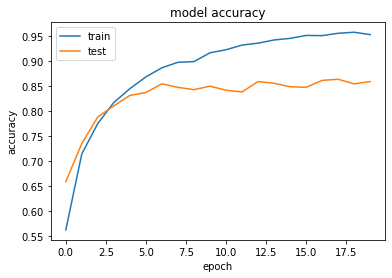

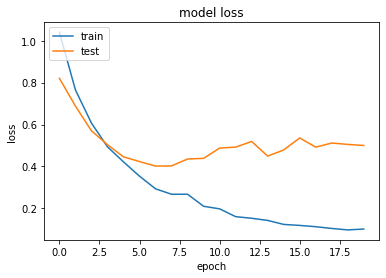

In [51]:
plot_history()

In [52]:
# select the best number of epochs

val_acc_per_epoch = history.history['val_accuracy']
best_number_of_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_number_of_epoch,))

Best epoch: 18


In [53]:
hypermodel = tuner.hypermodel.build(best_hps)

# re-train the model
hystory = hypermodel.fit(X_train_pad, y_train, 
                         epochs=best_number_of_epoch, 
                         validation_data=(X_val_pad, y_val))

Epoch 1/18
167/167 [==============================] - ETA: 15:55 - loss: 1.3916 - accuracy: 0.187 - ETA: 30s - loss: 1.3821 - accuracy: 0.2812  - ETA: 28s - loss: 1.3949 - accuracy: 0.239 - ETA: 27s - loss: 1.4013 - accuracy: 0.226 - ETA: 27s - loss: 1.3961 - accuracy: 0.237 - ETA: 27s - loss: 1.3838 - accuracy: 0.270 - ETA: 26s - loss: 1.3783 - accuracy: 0.299 - ETA: 26s - loss: 1.3704 - accuracy: 0.308 - ETA: 26s - loss: 1.3650 - accuracy: 0.312 - ETA: 26s - loss: 1.3638 - accuracy: 0.312 - ETA: 26s - loss: 1.3589 - accuracy: 0.315 - ETA: 26s - loss: 1.3613 - accuracy: 0.304 - ETA: 25s - loss: 1.3607 - accuracy: 0.307 - ETA: 25s - loss: 1.3564 - accuracy: 0.319 - ETA: 25s - loss: 1.3553 - accuracy: 0.322 - ETA: 25s - loss: 1.3523 - accuracy: 0.330 - ETA: 25s - loss: 1.3434 - accuracy: 0.343 - ETA: 24s - loss: 1.3385 - accuracy: 0.350 - ETA: 24s - loss: 1.3350 - accuracy: 0.355 - ETA: 24s - loss: 1.3316 - accuracy: 0.359 - ETA: 24s - loss: 1.3296 - accuracy: 0.363 - ETA: 24s - loss: 1

167/167 [==============================] - ETA: 31s - loss: 0.9018 - accuracy: 0.656 - ETA: 31s - loss: 0.8191 - accuracy: 0.734 - ETA: 31s - loss: 0.8229 - accuracy: 0.729 - ETA: 32s - loss: 0.8477 - accuracy: 0.710 - ETA: 32s - loss: 0.8560 - accuracy: 0.693 - ETA: 32s - loss: 0.8062 - accuracy: 0.708 - ETA: 31s - loss: 0.8067 - accuracy: 0.709 - ETA: 31s - loss: 0.8141 - accuracy: 0.710 - ETA: 31s - loss: 0.7882 - accuracy: 0.722 - ETA: 31s - loss: 0.7899 - accuracy: 0.725 - ETA: 31s - loss: 0.7878 - accuracy: 0.721 - ETA: 30s - loss: 0.7722 - accuracy: 0.724 - ETA: 30s - loss: 0.7750 - accuracy: 0.723 - ETA: 30s - loss: 0.7819 - accuracy: 0.721 - ETA: 30s - loss: 0.7658 - accuracy: 0.725 - ETA: 29s - loss: 0.8058 - accuracy: 0.705 - ETA: 29s - loss: 0.7991 - accuracy: 0.707 - ETA: 29s - loss: 0.7894 - accuracy: 0.711 - ETA: 29s - loss: 0.7805 - accuracy: 0.715 - ETA: 29s - loss: 0.7826 - accuracy: 0.714 - ETA: 28s - loss: 0.7879 - accuracy: 0.712 - ETA: 28s - loss: 0.7852 - accurac

167/167 [==============================] - ETA: 33s - loss: 0.9264 - accuracy: 0.656 - ETA: 33s - loss: 0.9670 - accuracy: 0.640 - ETA: 33s - loss: 0.8859 - accuracy: 0.677 - ETA: 33s - loss: 0.8475 - accuracy: 0.703 - ETA: 32s - loss: 0.8242 - accuracy: 0.706 - ETA: 34s - loss: 0.7899 - accuracy: 0.718 - ETA: 34s - loss: 0.8051 - accuracy: 0.696 - ETA: 34s - loss: 0.8045 - accuracy: 0.679 - ETA: 34s - loss: 0.8119 - accuracy: 0.670 - ETA: 34s - loss: 0.8049 - accuracy: 0.671 - ETA: 33s - loss: 0.7920 - accuracy: 0.676 - ETA: 33s - loss: 0.7834 - accuracy: 0.682 - ETA: 32s - loss: 0.7983 - accuracy: 0.680 - ETA: 32s - loss: 0.7900 - accuracy: 0.687 - ETA: 32s - loss: 0.7750 - accuracy: 0.695 - ETA: 31s - loss: 0.7668 - accuracy: 0.699 - ETA: 31s - loss: 0.7694 - accuracy: 0.691 - ETA: 31s - loss: 0.7571 - accuracy: 0.694 - ETA: 31s - loss: 0.7464 - accuracy: 0.699 - ETA: 31s - loss: 0.7454 - accuracy: 0.700 - ETA: 30s - loss: 0.7402 - accuracy: 0.700 - ETA: 30s - loss: 0.7304 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.6596 - accuracy: 0.812 - ETA: 33s - loss: 0.6645 - accuracy: 0.750 - ETA: 34s - loss: 0.6513 - accuracy: 0.750 - ETA: 34s - loss: 0.6066 - accuracy: 0.757 - ETA: 33s - loss: 0.6009 - accuracy: 0.750 - ETA: 33s - loss: 0.5875 - accuracy: 0.765 - ETA: 33s - loss: 0.5667 - accuracy: 0.776 - ETA: 33s - loss: 0.5585 - accuracy: 0.781 - ETA: 32s - loss: 0.5818 - accuracy: 0.770 - ETA: 32s - loss: 0.5852 - accuracy: 0.771 - ETA: 32s - loss: 0.5690 - accuracy: 0.778 - ETA: 32s - loss: 0.5678 - accuracy: 0.778 - ETA: 32s - loss: 0.5549 - accuracy: 0.781 - ETA: 31s - loss: 0.5622 - accuracy: 0.779 - ETA: 31s - loss: 0.5586 - accuracy: 0.781 - ETA: 31s - loss: 0.5398 - accuracy: 0.793 - ETA: 31s - loss: 0.5337 - accuracy: 0.794 - ETA: 30s - loss: 0.5268 - accuracy: 0.800 - ETA: 30s - loss: 0.5146 - accuracy: 0.805 - ETA: 30s - loss: 0.5022 - accuracy: 0.807 - ETA: 29s - loss: 0.5019 - accuracy: 0.808 - ETA: 29s - loss: 0.4983 - accurac

167/167 [==============================] - ETA: 33s - loss: 0.3342 - accuracy: 0.906 - ETA: 32s - loss: 0.4628 - accuracy: 0.843 - ETA: 32s - loss: 0.3916 - accuracy: 0.875 - ETA: 33s - loss: 0.3931 - accuracy: 0.867 - ETA: 33s - loss: 0.4277 - accuracy: 0.843 - ETA: 33s - loss: 0.4310 - accuracy: 0.849 - ETA: 33s - loss: 0.4436 - accuracy: 0.834 - ETA: 33s - loss: 0.4652 - accuracy: 0.828 - ETA: 33s - loss: 0.4633 - accuracy: 0.822 - ETA: 32s - loss: 0.4438 - accuracy: 0.834 - ETA: 32s - loss: 0.4723 - accuracy: 0.823 - ETA: 32s - loss: 0.4646 - accuracy: 0.822 - ETA: 32s - loss: 0.4661 - accuracy: 0.822 - ETA: 32s - loss: 0.4556 - accuracy: 0.823 - ETA: 32s - loss: 0.4357 - accuracy: 0.831 - ETA: 32s - loss: 0.4319 - accuracy: 0.834 - ETA: 31s - loss: 0.4279 - accuracy: 0.836 - ETA: 31s - loss: 0.4240 - accuracy: 0.840 - ETA: 31s - loss: 0.4151 - accuracy: 0.843 - ETA: 31s - loss: 0.4107 - accuracy: 0.846 - ETA: 30s - loss: 0.4069 - accuracy: 0.848 - ETA: 30s - loss: 0.4110 - accurac

167/167 [==============================] - ETA: 33s - loss: 0.5418 - accuracy: 0.812 - ETA: 36s - loss: 0.4415 - accuracy: 0.859 - ETA: 38s - loss: 0.4574 - accuracy: 0.822 - ETA: 38s - loss: 0.4447 - accuracy: 0.828 - ETA: 38s - loss: 0.4191 - accuracy: 0.837 - ETA: 38s - loss: 0.4416 - accuracy: 0.843 - ETA: 38s - loss: 0.4066 - accuracy: 0.861 - ETA: 37s - loss: 0.4096 - accuracy: 0.859 - ETA: 37s - loss: 0.3924 - accuracy: 0.864 - ETA: 37s - loss: 0.3877 - accuracy: 0.865 - ETA: 36s - loss: 0.3756 - accuracy: 0.872 - ETA: 35s - loss: 0.3785 - accuracy: 0.867 - ETA: 35s - loss: 0.3704 - accuracy: 0.870 - ETA: 35s - loss: 0.3661 - accuracy: 0.868 - ETA: 34s - loss: 0.3663 - accuracy: 0.868 - ETA: 34s - loss: 0.3698 - accuracy: 0.863 - ETA: 33s - loss: 0.3840 - accuracy: 0.856 - ETA: 33s - loss: 0.3831 - accuracy: 0.855 - ETA: 33s - loss: 0.3910 - accuracy: 0.855 - ETA: 33s - loss: 0.3935 - accuracy: 0.853 - ETA: 33s - loss: 0.4025 - accuracy: 0.851 - ETA: 33s - loss: 0.3976 - accurac

167/167 [==============================] - ETA: 33s - loss: 0.3011 - accuracy: 0.906 - ETA: 33s - loss: 0.2293 - accuracy: 0.937 - ETA: 33s - loss: 0.2913 - accuracy: 0.916 - ETA: 35s - loss: 0.2892 - accuracy: 0.906 - ETA: 36s - loss: 0.2691 - accuracy: 0.912 - ETA: 36s - loss: 0.2482 - accuracy: 0.927 - ETA: 36s - loss: 0.2574 - accuracy: 0.928 - ETA: 35s - loss: 0.2475 - accuracy: 0.929 - ETA: 35s - loss: 0.2505 - accuracy: 0.923 - ETA: 34s - loss: 0.2548 - accuracy: 0.921 - ETA: 34s - loss: 0.2702 - accuracy: 0.911 - ETA: 34s - loss: 0.2760 - accuracy: 0.914 - ETA: 33s - loss: 0.2798 - accuracy: 0.908 - ETA: 33s - loss: 0.2691 - accuracy: 0.912 - ETA: 33s - loss: 0.2681 - accuracy: 0.914 - ETA: 32s - loss: 0.2702 - accuracy: 0.912 - ETA: 32s - loss: 0.2686 - accuracy: 0.911 - ETA: 32s - loss: 0.2720 - accuracy: 0.909 - ETA: 31s - loss: 0.2640 - accuracy: 0.912 - ETA: 31s - loss: 0.2757 - accuracy: 0.906 - ETA: 31s - loss: 0.2746 - accuracy: 0.904 - ETA: 31s - loss: 0.2789 - accurac

167/167 [==============================] - ETA: 37s - loss: 0.3602 - accuracy: 0.906 - ETA: 34s - loss: 0.2601 - accuracy: 0.921 - ETA: 34s - loss: 0.2647 - accuracy: 0.906 - ETA: 34s - loss: 0.2659 - accuracy: 0.898 - ETA: 33s - loss: 0.2478 - accuracy: 0.912 - ETA: 33s - loss: 0.2336 - accuracy: 0.921 - ETA: 33s - loss: 0.2231 - accuracy: 0.928 - ETA: 32s - loss: 0.2023 - accuracy: 0.937 - ETA: 32s - loss: 0.2232 - accuracy: 0.923 - ETA: 31s - loss: 0.2355 - accuracy: 0.921 - ETA: 31s - loss: 0.2279 - accuracy: 0.923 - ETA: 31s - loss: 0.2260 - accuracy: 0.919 - ETA: 31s - loss: 0.2305 - accuracy: 0.915 - ETA: 31s - loss: 0.2234 - accuracy: 0.917 - ETA: 30s - loss: 0.2281 - accuracy: 0.920 - ETA: 30s - loss: 0.2279 - accuracy: 0.919 - ETA: 30s - loss: 0.2259 - accuracy: 0.917 - ETA: 30s - loss: 0.2486 - accuracy: 0.908 - ETA: 30s - loss: 0.2442 - accuracy: 0.907 - ETA: 30s - loss: 0.2478 - accuracy: 0.906 - ETA: 29s - loss: 0.2451 - accuracy: 0.906 - ETA: 29s - loss: 0.2437 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.2703 - accuracy: 0.937 - ETA: 39s - loss: 0.2565 - accuracy: 0.921 - ETA: 40s - loss: 0.2371 - accuracy: 0.916 - ETA: 39s - loss: 0.2230 - accuracy: 0.914 - ETA: 38s - loss: 0.2190 - accuracy: 0.918 - ETA: 37s - loss: 0.1991 - accuracy: 0.927 - ETA: 36s - loss: 0.1862 - accuracy: 0.933 - ETA: 36s - loss: 0.1715 - accuracy: 0.941 - ETA: 35s - loss: 0.1825 - accuracy: 0.937 - ETA: 35s - loss: 0.1897 - accuracy: 0.937 - ETA: 35s - loss: 0.1761 - accuracy: 0.943 - ETA: 34s - loss: 0.1794 - accuracy: 0.940 - ETA: 34s - loss: 0.1818 - accuracy: 0.937 - ETA: 34s - loss: 0.1889 - accuracy: 0.930 - ETA: 33s - loss: 0.1978 - accuracy: 0.925 - ETA: 33s - loss: 0.1957 - accuracy: 0.927 - ETA: 32s - loss: 0.1936 - accuracy: 0.930 - ETA: 32s - loss: 0.1944 - accuracy: 0.930 - ETA: 31s - loss: 0.1969 - accuracy: 0.929 - ETA: 31s - loss: 0.1934 - accuracy: 0.929 - ETA: 31s - loss: 0.1928 - accuracy: 0.928 - ETA: 30s - loss: 0.1898 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.1565 - accuracy: 0.968 - ETA: 35s - loss: 0.2693 - accuracy: 0.859 - ETA: 34s - loss: 0.3856 - accuracy: 0.843 - ETA: 34s - loss: 0.4399 - accuracy: 0.828 - ETA: 33s - loss: 0.4958 - accuracy: 0.787 - ETA: 33s - loss: 0.5363 - accuracy: 0.750 - ETA: 33s - loss: 0.5692 - accuracy: 0.723 - ETA: 32s - loss: 0.5421 - accuracy: 0.734 - ETA: 32s - loss: 0.5067 - accuracy: 0.753 - ETA: 32s - loss: 0.4754 - accuracy: 0.771 - ETA: 31s - loss: 0.4561 - accuracy: 0.784 - ETA: 31s - loss: 0.4548 - accuracy: 0.786 - ETA: 31s - loss: 0.4457 - accuracy: 0.793 - ETA: 31s - loss: 0.4607 - accuracy: 0.792 - ETA: 31s - loss: 0.4521 - accuracy: 0.795 - ETA: 30s - loss: 0.4461 - accuracy: 0.800 - ETA: 30s - loss: 0.4370 - accuracy: 0.805 - ETA: 30s - loss: 0.4352 - accuracy: 0.805 - ETA: 30s - loss: 0.4225 - accuracy: 0.812 - ETA: 30s - loss: 0.4197 - accuracy: 0.812 - ETA: 29s - loss: 0.4105 - accuracy: 0.818 - ETA: 29s - loss: 0.4257 - accurac

167/167 [==============================] - ETA: 33s - loss: 0.1500 - accuracy: 0.968 - ETA: 35s - loss: 0.1148 - accuracy: 0.968 - ETA: 35s - loss: 0.1153 - accuracy: 0.958 - ETA: 37s - loss: 0.1379 - accuracy: 0.937 - ETA: 37s - loss: 0.1808 - accuracy: 0.937 - ETA: 37s - loss: 0.1895 - accuracy: 0.937 - ETA: 36s - loss: 0.1773 - accuracy: 0.942 - ETA: 36s - loss: 0.1649 - accuracy: 0.945 - ETA: 35s - loss: 0.1810 - accuracy: 0.937 - ETA: 35s - loss: 0.1768 - accuracy: 0.940 - ETA: 34s - loss: 0.1820 - accuracy: 0.937 - ETA: 34s - loss: 0.1733 - accuracy: 0.940 - ETA: 34s - loss: 0.1739 - accuracy: 0.937 - ETA: 33s - loss: 0.1739 - accuracy: 0.935 - ETA: 33s - loss: 0.1750 - accuracy: 0.933 - ETA: 33s - loss: 0.1693 - accuracy: 0.935 - ETA: 32s - loss: 0.1697 - accuracy: 0.937 - ETA: 32s - loss: 0.1729 - accuracy: 0.934 - ETA: 32s - loss: 0.1746 - accuracy: 0.934 - ETA: 32s - loss: 0.1714 - accuracy: 0.935 - ETA: 31s - loss: 0.1712 - accuracy: 0.936 - ETA: 31s - loss: 0.1676 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.0932 - accuracy: 0.937 - ETA: 33s - loss: 0.1053 - accuracy: 0.953 - ETA: 33s - loss: 0.0978 - accuracy: 0.958 - ETA: 33s - loss: 0.0981 - accuracy: 0.960 - ETA: 33s - loss: 0.0923 - accuracy: 0.962 - ETA: 32s - loss: 0.0986 - accuracy: 0.963 - ETA: 32s - loss: 0.0988 - accuracy: 0.964 - ETA: 32s - loss: 0.0957 - accuracy: 0.968 - ETA: 32s - loss: 0.0910 - accuracy: 0.968 - ETA: 32s - loss: 0.0889 - accuracy: 0.971 - ETA: 32s - loss: 0.0864 - accuracy: 0.974 - ETA: 31s - loss: 0.0893 - accuracy: 0.971 - ETA: 31s - loss: 0.0866 - accuracy: 0.971 - ETA: 31s - loss: 0.0903 - accuracy: 0.966 - ETA: 31s - loss: 0.0968 - accuracy: 0.962 - ETA: 30s - loss: 0.0964 - accuracy: 0.962 - ETA: 30s - loss: 0.1094 - accuracy: 0.955 - ETA: 30s - loss: 0.1107 - accuracy: 0.954 - ETA: 30s - loss: 0.1143 - accuracy: 0.952 - ETA: 30s - loss: 0.1164 - accuracy: 0.951 - ETA: 29s - loss: 0.1177 - accuracy: 0.952 - ETA: 29s - loss: 0.1261 - accurac

167/167 [==============================] - ETA: 35s - loss: 0.0818 - accuracy: 0.968 - ETA: 34s - loss: 0.1363 - accuracy: 0.937 - ETA: 34s - loss: 0.1652 - accuracy: 0.937 - ETA: 34s - loss: 0.1553 - accuracy: 0.953 - ETA: 33s - loss: 0.1794 - accuracy: 0.943 - ETA: 33s - loss: 0.1981 - accuracy: 0.942 - ETA: 33s - loss: 0.1778 - accuracy: 0.950 - ETA: 33s - loss: 0.1771 - accuracy: 0.949 - ETA: 32s - loss: 0.1905 - accuracy: 0.944 - ETA: 32s - loss: 0.1935 - accuracy: 0.943 - ETA: 32s - loss: 0.1876 - accuracy: 0.946 - ETA: 32s - loss: 0.1842 - accuracy: 0.947 - ETA: 31s - loss: 0.1789 - accuracy: 0.947 - ETA: 31s - loss: 0.1785 - accuracy: 0.948 - ETA: 31s - loss: 0.1736 - accuracy: 0.947 - ETA: 31s - loss: 0.1752 - accuracy: 0.943 - ETA: 31s - loss: 0.1815 - accuracy: 0.939 - ETA: 30s - loss: 0.1813 - accuracy: 0.939 - ETA: 30s - loss: 0.1766 - accuracy: 0.939 - ETA: 30s - loss: 0.1715 - accuracy: 0.940 - ETA: 30s - loss: 0.1698 - accuracy: 0.940 - ETA: 29s - loss: 0.1640 - accurac

167/167 [==============================] - ETA: 33s - loss: 0.1469 - accuracy: 0.937 - ETA: 32s - loss: 0.0921 - accuracy: 0.968 - ETA: 31s - loss: 0.1376 - accuracy: 0.947 - ETA: 32s - loss: 0.1285 - accuracy: 0.945 - ETA: 32s - loss: 0.1390 - accuracy: 0.943 - ETA: 32s - loss: 0.1243 - accuracy: 0.953 - ETA: 32s - loss: 0.1191 - accuracy: 0.950 - ETA: 31s - loss: 0.1211 - accuracy: 0.949 - ETA: 31s - loss: 0.1334 - accuracy: 0.947 - ETA: 31s - loss: 0.1374 - accuracy: 0.950 - ETA: 30s - loss: 0.1294 - accuracy: 0.951 - ETA: 30s - loss: 0.1255 - accuracy: 0.955 - ETA: 30s - loss: 0.1216 - accuracy: 0.956 - ETA: 30s - loss: 0.1195 - accuracy: 0.957 - ETA: 30s - loss: 0.1132 - accuracy: 0.960 - ETA: 30s - loss: 0.1144 - accuracy: 0.959 - ETA: 29s - loss: 0.1105 - accuracy: 0.961 - ETA: 29s - loss: 0.1049 - accuracy: 0.963 - ETA: 29s - loss: 0.1015 - accuracy: 0.963 - ETA: 29s - loss: 0.1102 - accuracy: 0.962 - ETA: 29s - loss: 0.1122 - accuracy: 0.962 - ETA: 29s - loss: 0.1092 - accurac

167/167 [==============================] - ETA: 32s - loss: 0.1725 - accuracy: 0.937 - ETA: 33s - loss: 0.1099 - accuracy: 0.953 - ETA: 32s - loss: 0.0966 - accuracy: 0.968 - ETA: 33s - loss: 0.1002 - accuracy: 0.960 - ETA: 35s - loss: 0.0902 - accuracy: 0.968 - ETA: 35s - loss: 0.0924 - accuracy: 0.968 - ETA: 35s - loss: 0.1041 - accuracy: 0.955 - ETA: 35s - loss: 0.0943 - accuracy: 0.960 - ETA: 34s - loss: 0.0974 - accuracy: 0.954 - ETA: 34s - loss: 0.0963 - accuracy: 0.953 - ETA: 34s - loss: 0.1008 - accuracy: 0.946 - ETA: 34s - loss: 0.0993 - accuracy: 0.947 - ETA: 35s - loss: 0.1101 - accuracy: 0.947 - ETA: 35s - loss: 0.1069 - accuracy: 0.948 - ETA: 34s - loss: 0.1054 - accuracy: 0.947 - ETA: 34s - loss: 0.1128 - accuracy: 0.947 - ETA: 34s - loss: 0.1088 - accuracy: 0.950 - ETA: 33s - loss: 0.1050 - accuracy: 0.951 - ETA: 33s - loss: 0.1040 - accuracy: 0.952 - ETA: 33s - loss: 0.1028 - accuracy: 0.953 - ETA: 32s - loss: 0.1017 - accuracy: 0.953 - ETA: 32s - loss: 0.1008 - accurac

167/167 [==============================] - ETA: 40s - loss: 0.0845 - accuracy: 0.968 - ETA: 44s - loss: 0.1435 - accuracy: 0.937 - ETA: 43s - loss: 0.1203 - accuracy: 0.947 - ETA: 41s - loss: 0.1274 - accuracy: 0.945 - ETA: 41s - loss: 0.1234 - accuracy: 0.943 - ETA: 40s - loss: 0.1633 - accuracy: 0.942 - ETA: 40s - loss: 0.1520 - accuracy: 0.950 - ETA: 39s - loss: 0.1384 - accuracy: 0.957 - ETA: 38s - loss: 0.1300 - accuracy: 0.958 - ETA: 37s - loss: 0.1357 - accuracy: 0.956 - ETA: 36s - loss: 0.1323 - accuracy: 0.957 - ETA: 36s - loss: 0.1348 - accuracy: 0.955 - ETA: 35s - loss: 0.1340 - accuracy: 0.956 - ETA: 35s - loss: 0.1299 - accuracy: 0.957 - ETA: 34s - loss: 0.1370 - accuracy: 0.954 - ETA: 34s - loss: 0.1295 - accuracy: 0.957 - ETA: 34s - loss: 0.1287 - accuracy: 0.957 - ETA: 34s - loss: 0.1244 - accuracy: 0.960 - ETA: 34s - loss: 0.1229 - accuracy: 0.960 - ETA: 34s - loss: 0.1233 - accuracy: 0.959 - ETA: 34s - loss: 0.1212 - accuracy: 0.958 - ETA: 33s - loss: 0.1181 - accurac

167/167 [==============================] - ETA: 39s - loss: 0.1407 - accuracy: 0.968 - ETA: 36s - loss: 0.1066 - accuracy: 0.968 - ETA: 35s - loss: 0.1163 - accuracy: 0.947 - ETA: 34s - loss: 0.1107 - accuracy: 0.945 - ETA: 34s - loss: 0.1128 - accuracy: 0.950 - ETA: 34s - loss: 0.1168 - accuracy: 0.942 - ETA: 33s - loss: 0.1316 - accuracy: 0.937 - ETA: 34s - loss: 0.1329 - accuracy: 0.933 - ETA: 34s - loss: 0.1261 - accuracy: 0.941 - ETA: 34s - loss: 0.1143 - accuracy: 0.946 - ETA: 34s - loss: 0.1127 - accuracy: 0.948 - ETA: 33s - loss: 0.1221 - accuracy: 0.942 - ETA: 33s - loss: 0.1226 - accuracy: 0.942 - ETA: 33s - loss: 0.1171 - accuracy: 0.944 - ETA: 32s - loss: 0.1141 - accuracy: 0.947 - ETA: 32s - loss: 0.1096 - accuracy: 0.949 - ETA: 32s - loss: 0.1056 - accuracy: 0.952 - ETA: 31s - loss: 0.1020 - accuracy: 0.953 - ETA: 31s - loss: 0.1035 - accuracy: 0.950 - ETA: 31s - loss: 0.1047 - accuracy: 0.948 - ETA: 31s - loss: 0.1137 - accuracy: 0.947 - ETA: 30s - loss: 0.1105 - accurac

167/167 [==============================] - ETA: 34s - loss: 0.0050 - accuracy: 1.000 - ETA: 34s - loss: 0.0231 - accuracy: 1.000 - ETA: 37s - loss: 0.0936 - accuracy: 0.979 - ETA: 37s - loss: 0.0888 - accuracy: 0.984 - ETA: 36s - loss: 0.1195 - accuracy: 0.975 - ETA: 36s - loss: 0.1166 - accuracy: 0.974 - ETA: 35s - loss: 0.1250 - accuracy: 0.964 - ETA: 35s - loss: 0.1229 - accuracy: 0.968 - ETA: 35s - loss: 0.1358 - accuracy: 0.958 - ETA: 34s - loss: 0.1446 - accuracy: 0.946 - ETA: 34s - loss: 0.1368 - accuracy: 0.948 - ETA: 33s - loss: 0.1547 - accuracy: 0.945 - ETA: 33s - loss: 0.1502 - accuracy: 0.947 - ETA: 33s - loss: 0.1544 - accuracy: 0.944 - ETA: 32s - loss: 0.1460 - accuracy: 0.947 - ETA: 32s - loss: 0.1458 - accuracy: 0.947 - ETA: 32s - loss: 0.1424 - accuracy: 0.948 - ETA: 31s - loss: 0.1481 - accuracy: 0.946 - ETA: 31s - loss: 0.1481 - accuracy: 0.945 - ETA: 31s - loss: 0.1470 - accuracy: 0.945 - ETA: 31s - loss: 0.1435 - accuracy: 0.946 - ETA: 30s - loss: 0.1439 - accurac

In [54]:
# check external validity on the test set
score = hypermodel.evaluate(X_test_pad, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5167689323425293
Test accuracy: 0.8571428656578064


In [55]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test, axis=1)
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       248
           1       0.80      0.87      0.83       268
           2       0.90      0.92      0.91       206
           3       0.82      0.81      0.82       202

    accuracy                           0.84       924
   macro avg       0.85      0.84      0.84       924
weighted avg       0.84      0.84      0.84       924



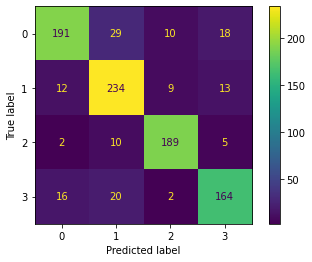

In [56]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_true))
cm.plot()

### Get the cross-validated accuracy of the selected model

In [57]:
def build_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(best_hps.get('lstm_1'), 
                                 return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(best_hps.get('lstm_2'), 
                                 return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(best_hps.get('lstm_3'), 
                                 return_sequences=False)))
    model.add(Dense(class_num, 
                    activation = 'softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
    return model

In [58]:
# set up the 3-fold cross validation to get a more accurate estimate of the accuracy of the model

num_folds = 3

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((X_train_pad, X_val_pad), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

for train, test in kfold.split(inputs, targets):
    model = build_model()
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=128,
              epochs=best_number_of_epoch)
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/18
33/33 [==============================] - ETA: 3:20 - loss: 1.3830 - accuracy: 0.31 - ETA: 14s - loss: 1.3787 - accuracy: 0.3203 - ETA: 13s - loss: 1.3698 - accuracy: 0.325 - ETA: 13s - loss: 1.3648 - accuracy: 0.326 - ETA: 12s - loss: 1.3547 - accuracy: 0.337 - ETA: 12s - loss: 1.3547 - accuracy: 0.341 - ETA: 11s - loss: 1.3461 - accuracy: 0.347 - ETA: 11s - loss: 1.3393 - accuracy: 0.360 - ETA: 11s - loss: 1.3330 - accuracy: 0.363 - ETA: 10s - loss: 1.3258 - accuracy: 0.366 - ETA: 10s - loss: 1.3182 - accuracy: 0.372 - ETA: 9s - loss: 1.3069 - accuracy: 0.382 - ETA: 9s - loss: 1.3017 - accuracy: 0.38 - ETA: 8s - loss: 1.2933 - accuracy: 0.39 - ETA: 8s - loss: 1.2823 - accuracy: 0.40 - ETA: 7s - loss: 1.2693 - accuracy: 0.41 - ETA: 7s - loss: 1.2646 - accuracy: 0.42 - ETA: 7s - loss: 1.2652 - accuracy: 0.42 - ETA: 6s - loss: 1.2579 - accuracy: 0.42 - ETA: 6s - loss: 1.2468 - accu

33/33 [==============================] - ETA: 21s - loss: 0.5592 - accuracy: 0.812 - ETA: 18s - loss: 0.5346 - accuracy: 0.820 - ETA: 18s - loss: 0.5288 - accuracy: 0.817 - ETA: 17s - loss: 0.5417 - accuracy: 0.808 - ETA: 16s - loss: 0.5470 - accuracy: 0.807 - ETA: 16s - loss: 0.5562 - accuracy: 0.807 - ETA: 15s - loss: 0.5423 - accuracy: 0.810 - ETA: 14s - loss: 0.5399 - accuracy: 0.809 - ETA: 14s - loss: 0.5537 - accuracy: 0.805 - ETA: 13s - loss: 0.5621 - accuracy: 0.803 - ETA: 13s - loss: 0.5740 - accuracy: 0.801 - ETA: 12s - loss: 0.5689 - accuracy: 0.800 - ETA: 12s - loss: 0.5606 - accuracy: 0.804 - ETA: 11s - loss: 0.5601 - accuracy: 0.802 - ETA: 10s - loss: 0.5652 - accuracy: 0.800 - ETA: 10s - loss: 0.5715 - accuracy: 0.797 - ETA: 9s - loss: 0.5771 - accuracy: 0.794 - ETA: 8s - loss: 0.5767 - accuracy: 0.79 - ETA: 8s - loss: 0.5719 - accuracy: 0.79 - ETA: 7s - loss: 0.5717 - accuracy: 0.79 - ETA: 7s - loss: 0.5671 - accuracy: 0.79 - ETA: 6s - loss: 0.5654 - accuracy: 0.79 - ET

33/33 [==============================] - ETA: 20s - loss: 0.2635 - accuracy: 0.890 - ETA: 21s - loss: 0.2572 - accuracy: 0.906 - ETA: 21s - loss: 0.2530 - accuracy: 0.908 - ETA: 19s - loss: 0.2671 - accuracy: 0.902 - ETA: 18s - loss: 0.2602 - accuracy: 0.907 - ETA: 17s - loss: 0.2660 - accuracy: 0.902 - ETA: 17s - loss: 0.2698 - accuracy: 0.900 - ETA: 16s - loss: 0.2695 - accuracy: 0.901 - ETA: 15s - loss: 0.2678 - accuracy: 0.902 - ETA: 14s - loss: 0.2791 - accuracy: 0.899 - ETA: 14s - loss: 0.2764 - accuracy: 0.899 - ETA: 13s - loss: 0.2741 - accuracy: 0.901 - ETA: 12s - loss: 0.2761 - accuracy: 0.898 - ETA: 12s - loss: 0.2872 - accuracy: 0.892 - ETA: 11s - loss: 0.2809 - accuracy: 0.894 - ETA: 10s - loss: 0.2805 - accuracy: 0.895 - ETA: 10s - loss: 0.2856 - accuracy: 0.893 - ETA: 9s - loss: 0.2870 - accuracy: 0.892 - ETA: 8s - loss: 0.2865 - accuracy: 0.89 - ETA: 8s - loss: 0.2882 - accuracy: 0.89 - ETA: 7s - loss: 0.2859 - accuracy: 0.89 - ETA: 6s - loss: 0.2877 - accuracy: 0.89 - 

33/33 [==============================] - ETA: 19s - loss: 0.1029 - accuracy: 0.976 - ETA: 20s - loss: 0.1508 - accuracy: 0.953 - ETA: 20s - loss: 0.1424 - accuracy: 0.953 - ETA: 19s - loss: 0.1634 - accuracy: 0.941 - ETA: 18s - loss: 0.1604 - accuracy: 0.942 - ETA: 17s - loss: 0.1552 - accuracy: 0.944 - ETA: 16s - loss: 0.1762 - accuracy: 0.936 - ETA: 16s - loss: 0.1761 - accuracy: 0.935 - ETA: 15s - loss: 0.1745 - accuracy: 0.938 - ETA: 14s - loss: 0.1793 - accuracy: 0.935 - ETA: 14s - loss: 0.1864 - accuracy: 0.933 - ETA: 13s - loss: 0.1865 - accuracy: 0.933 - ETA: 12s - loss: 0.1893 - accuracy: 0.930 - ETA: 12s - loss: 0.1870 - accuracy: 0.931 - ETA: 11s - loss: 0.1896 - accuracy: 0.931 - ETA: 10s - loss: 0.1840 - accuracy: 0.933 - ETA: 10s - loss: 0.1789 - accuracy: 0.935 - ETA: 9s - loss: 0.1793 - accuracy: 0.934 - ETA: 8s - loss: 0.1816 - accuracy: 0.93 - ETA: 8s - loss: 0.1796 - accuracy: 0.93 - ETA: 7s - loss: 0.1804 - accuracy: 0.93 - ETA: 6s - loss: 0.1816 - accuracy: 0.93 - 

33/33 [==============================] - ETA: 19s - loss: 0.8287 - accuracy: 0.687 - ETA: 19s - loss: 0.8714 - accuracy: 0.652 - ETA: 18s - loss: 0.8496 - accuracy: 0.658 - ETA: 18s - loss: 0.8442 - accuracy: 0.668 - ETA: 17s - loss: 0.8278 - accuracy: 0.679 - ETA: 17s - loss: 0.8218 - accuracy: 0.679 - ETA: 17s - loss: 0.8046 - accuracy: 0.692 - ETA: 16s - loss: 0.7964 - accuracy: 0.697 - ETA: 15s - loss: 0.8092 - accuracy: 0.690 - ETA: 14s - loss: 0.8059 - accuracy: 0.691 - ETA: 14s - loss: 0.8072 - accuracy: 0.687 - ETA: 13s - loss: 0.8051 - accuracy: 0.688 - ETA: 12s - loss: 0.7976 - accuracy: 0.690 - ETA: 12s - loss: 0.7947 - accuracy: 0.694 - ETA: 11s - loss: 0.7967 - accuracy: 0.693 - ETA: 10s - loss: 0.7856 - accuracy: 0.699 - ETA: 10s - loss: 0.7852 - accuracy: 0.699 - ETA: 9s - loss: 0.7785 - accuracy: 0.700 - ETA: 8s - loss: 0.7763 - accuracy: 0.70 - ETA: 8s - loss: 0.7690 - accuracy: 0.70 - ETA: 7s - loss: 0.7651 - accuracy: 0.70 - ETA: 6s - loss: 0.7658 - accuracy: 0.70 - 

33/33 [==============================] - ETA: 19s - loss: 0.3642 - accuracy: 0.867 - ETA: 19s - loss: 0.4182 - accuracy: 0.839 - ETA: 18s - loss: 0.4009 - accuracy: 0.854 - ETA: 18s - loss: 0.3990 - accuracy: 0.859 - ETA: 17s - loss: 0.3885 - accuracy: 0.862 - ETA: 16s - loss: 0.3895 - accuracy: 0.859 - ETA: 16s - loss: 0.3849 - accuracy: 0.862 - ETA: 15s - loss: 0.4079 - accuracy: 0.853 - ETA: 15s - loss: 0.4060 - accuracy: 0.855 - ETA: 14s - loss: 0.4024 - accuracy: 0.857 - ETA: 14s - loss: 0.4006 - accuracy: 0.858 - ETA: 13s - loss: 0.3920 - accuracy: 0.862 - ETA: 12s - loss: 0.3877 - accuracy: 0.864 - ETA: 12s - loss: 0.3824 - accuracy: 0.864 - ETA: 11s - loss: 0.3820 - accuracy: 0.864 - ETA: 10s - loss: 0.3861 - accuracy: 0.861 - ETA: 10s - loss: 0.3881 - accuracy: 0.861 - ETA: 9s - loss: 0.3872 - accuracy: 0.861 - ETA: 8s - loss: 0.3924 - accuracy: 0.85 - ETA: 8s - loss: 0.3958 - accuracy: 0.85 - ETA: 7s - loss: 0.3856 - accuracy: 0.86 - ETA: 6s - loss: 0.3832 - accuracy: 0.86 - 

33/33 [==============================] - ETA: 19s - loss: 0.2456 - accuracy: 0.914 - ETA: 19s - loss: 0.2129 - accuracy: 0.921 - ETA: 18s - loss: 0.2557 - accuracy: 0.898 - ETA: 18s - loss: 0.2385 - accuracy: 0.906 - ETA: 17s - loss: 0.2215 - accuracy: 0.915 - ETA: 16s - loss: 0.2298 - accuracy: 0.914 - ETA: 16s - loss: 0.2317 - accuracy: 0.909 - ETA: 15s - loss: 0.2384 - accuracy: 0.906 - ETA: 15s - loss: 0.2242 - accuracy: 0.912 - ETA: 14s - loss: 0.2353 - accuracy: 0.907 - ETA: 13s - loss: 0.2401 - accuracy: 0.907 - ETA: 13s - loss: 0.2334 - accuracy: 0.910 - ETA: 12s - loss: 0.2295 - accuracy: 0.912 - ETA: 11s - loss: 0.2281 - accuracy: 0.911 - ETA: 11s - loss: 0.2248 - accuracy: 0.912 - ETA: 10s - loss: 0.2281 - accuracy: 0.911 - ETA: 9s - loss: 0.2258 - accuracy: 0.913 - ETA: 9s - loss: 0.2237 - accuracy: 0.91 - ETA: 8s - loss: 0.2236 - accuracy: 0.91 - ETA: 8s - loss: 0.2216 - accuracy: 0.91 - ETA: 7s - loss: 0.2244 - accuracy: 0.91 - ETA: 6s - loss: 0.2278 - accuracy: 0.91 - ET

33/33 [==============================] - ETA: 24s - loss: 0.0980 - accuracy: 0.953 - ETA: 19s - loss: 0.1250 - accuracy: 0.949 - ETA: 19s - loss: 0.1317 - accuracy: 0.947 - ETA: 19s - loss: 0.1237 - accuracy: 0.953 - ETA: 18s - loss: 0.1174 - accuracy: 0.954 - ETA: 17s - loss: 0.1261 - accuracy: 0.951 - ETA: 16s - loss: 0.1292 - accuracy: 0.954 - ETA: 16s - loss: 0.1274 - accuracy: 0.957 - ETA: 15s - loss: 0.1279 - accuracy: 0.957 - ETA: 14s - loss: 0.1243 - accuracy: 0.960 - ETA: 14s - loss: 0.1283 - accuracy: 0.956 - ETA: 13s - loss: 0.1288 - accuracy: 0.955 - ETA: 12s - loss: 0.1348 - accuracy: 0.951 - ETA: 12s - loss: 0.1408 - accuracy: 0.948 - ETA: 11s - loss: 0.1451 - accuracy: 0.945 - ETA: 10s - loss: 0.1448 - accuracy: 0.945 - ETA: 10s - loss: 0.1406 - accuracy: 0.946 - ETA: 9s - loss: 0.1393 - accuracy: 0.947 - ETA: 9s - loss: 0.1431 - accuracy: 0.94 - ETA: 8s - loss: 0.1454 - accuracy: 0.94 - ETA: 7s - loss: 0.1449 - accuracy: 0.94 - ETA: 7s - loss: 0.1435 - accuracy: 0.94 - 

33/33 [==============================] - ETA: 20s - loss: 0.6545 - accuracy: 0.710 - ETA: 19s - loss: 0.5597 - accuracy: 0.789 - ETA: 19s - loss: 0.5706 - accuracy: 0.789 - ETA: 18s - loss: 0.5726 - accuracy: 0.791 - ETA: 17s - loss: 0.5803 - accuracy: 0.787 - ETA: 16s - loss: 0.5771 - accuracy: 0.791 - ETA: 16s - loss: 0.5853 - accuracy: 0.783 - ETA: 15s - loss: 0.5840 - accuracy: 0.787 - ETA: 15s - loss: 0.5971 - accuracy: 0.782 - ETA: 14s - loss: 0.6003 - accuracy: 0.777 - ETA: 13s - loss: 0.5970 - accuracy: 0.781 - ETA: 13s - loss: 0.5986 - accuracy: 0.780 - ETA: 12s - loss: 0.6005 - accuracy: 0.777 - ETA: 11s - loss: 0.5969 - accuracy: 0.780 - ETA: 11s - loss: 0.6026 - accuracy: 0.778 - ETA: 10s - loss: 0.6058 - accuracy: 0.776 - ETA: 9s - loss: 0.6133 - accuracy: 0.773 - ETA: 9s - loss: 0.6206 - accuracy: 0.77 - ETA: 8s - loss: 0.6266 - accuracy: 0.77 - ETA: 8s - loss: 0.6177 - accuracy: 0.77 - ETA: 7s - loss: 0.6164 - accuracy: 0.77 - ETA: 6s - loss: 0.6185 - accuracy: 0.77 - ET

33/33 [==============================] - ETA: 21s - loss: 0.3449 - accuracy: 0.875 - ETA: 23s - loss: 0.3160 - accuracy: 0.890 - ETA: 21s - loss: 0.3146 - accuracy: 0.895 - ETA: 19s - loss: 0.3184 - accuracy: 0.888 - ETA: 18s - loss: 0.3065 - accuracy: 0.895 - ETA: 18s - loss: 0.2998 - accuracy: 0.901 - ETA: 17s - loss: 0.2959 - accuracy: 0.900 - ETA: 16s - loss: 0.2883 - accuracy: 0.904 - ETA: 15s - loss: 0.3021 - accuracy: 0.899 - ETA: 14s - loss: 0.3056 - accuracy: 0.895 - ETA: 14s - loss: 0.3068 - accuracy: 0.895 - ETA: 13s - loss: 0.3065 - accuracy: 0.895 - ETA: 12s - loss: 0.3006 - accuracy: 0.896 - ETA: 12s - loss: 0.2979 - accuracy: 0.895 - ETA: 11s - loss: 0.3027 - accuracy: 0.894 - ETA: 10s - loss: 0.3048 - accuracy: 0.893 - ETA: 10s - loss: 0.3064 - accuracy: 0.892 - ETA: 9s - loss: 0.3068 - accuracy: 0.892 - ETA: 8s - loss: 0.3028 - accuracy: 0.89 - ETA: 8s - loss: 0.3062 - accuracy: 0.89 - ETA: 7s - loss: 0.3104 - accuracy: 0.89 - ETA: 7s - loss: 0.3125 - accuracy: 0.89 - 

33/33 [==============================] - ETA: 20s - loss: 0.1512 - accuracy: 0.953 - ETA: 19s - loss: 0.1895 - accuracy: 0.941 - ETA: 19s - loss: 0.1703 - accuracy: 0.942 - ETA: 18s - loss: 0.1714 - accuracy: 0.939 - ETA: 17s - loss: 0.1862 - accuracy: 0.932 - ETA: 17s - loss: 0.1927 - accuracy: 0.932 - ETA: 17s - loss: 0.1905 - accuracy: 0.933 - ETA: 16s - loss: 0.1888 - accuracy: 0.931 - ETA: 15s - loss: 0.1778 - accuracy: 0.936 - ETA: 15s - loss: 0.1825 - accuracy: 0.932 - ETA: 14s - loss: 0.1875 - accuracy: 0.931 - ETA: 13s - loss: 0.1876 - accuracy: 0.930 - ETA: 13s - loss: 0.1852 - accuracy: 0.930 - ETA: 12s - loss: 0.1794 - accuracy: 0.933 - ETA: 11s - loss: 0.1813 - accuracy: 0.932 - ETA: 11s - loss: 0.1831 - accuracy: 0.931 - ETA: 10s - loss: 0.1840 - accuracy: 0.931 - ETA: 9s - loss: 0.1872 - accuracy: 0.930 - ETA: 9s - loss: 0.1875 - accuracy: 0.92 - ETA: 8s - loss: 0.1887 - accuracy: 0.92 - ETA: 7s - loss: 0.1887 - accuracy: 0.93 - ETA: 7s - loss: 0.1905 - accuracy: 0.93 - 

In [59]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5805109143257141 - Accuracy: 82.2330117225647%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.7853479385375977 - Accuracy: 78.72753739356995%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.6688239574432373 - Accuracy: 80.52452802658081%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 80.49502571423848 (+- 1.4312559420861708)
> Loss: 0.6782276034355164
------------------------------------------------------------------------


### Save the model to use it for the subsequent tasks

In [60]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [61]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [62]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [63]:
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [64]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test_pad, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 81.39%


## 2. Model with Embedding, Convolutional layer and LSTM

In [65]:
#model = Sequential()
#model.add(embedding_layer)
#model.add(Conv1D(128, 3, activation="relu"))
#model.add(MaxPooling1D(2))
#model.add(LSTM(200, return_sequences=True))
#model.add(Dropout(0.6))
#model.add(Flatten())
#model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(50, activation='relu'))
#model.add(Dense(class_num, activation='softmax'))
#
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#
#model.summary()

In [66]:
#history = model.fit(X_train_pad, 
#                    y_train, 
#                    epochs=20, 
#                    batch_size=128,
#                    validation_data=(X_val_pad, y_val))

In [67]:
#plot_history()

In [68]:
#y_pred = np.argmax(model.predict(X_test_pad), axis=1)
#y_true = np.argmax(y_test, axis=1)
#
#print(metrics.classification_report(y_pred, y_true))

In [69]:
#cm = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_true))
#cm.plot()

## 3. Model with LSTM and Convvolutional layers

In [70]:
#model = Sequential()
#model.add(embedding_layer)
#model.add(LSTM(100, return_sequences=True))
#model.add(Dropout(0.2))
#model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
#model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
#model.add(GlobalMaxPooling1D())
#model.add(Flatten())
##model.add(Dropout(0.2))
#model.add(Dense(128,activation='relu'))
#model.add(Dense(class_num, activation='softmax'))
#
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
#
#model.summary()

In [71]:
#history = model.fit(X_train_pad, 
#                    y_train, 
#                    epochs=20, 
#                    batch_size=128,
#                    validation_data=(X_val_pad, y_val))

In [72]:
#plot_history()

In [73]:
#y_pred = np.argmax(model.predict(X_test_pad), axis=1)
#y_true = np.argmax(y_test, axis=1)
#
#print(metrics.classification_report(y_pred, y_true))

In [74]:
#cm = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_true))
#cm.plot()